# Einführung

Sehr geehrter Herr Haas,

anbei finden Sie erste Ergebnisse meiner Arbeit. 
Zur Analyse der Zeitreihen nutze ich hauptsächlich die Python Library Darts (publiziert 2020 von Unit8 auf [GitHub](https://unit8co.github.io/darts/README.html)). Diese bietet eine Art standardiserte Oberfläche für relevante ML Libraries wie Sklearn, PyTorch oder MLflow und basiert auf Numpy und Pandas. Die Dokumentation ist hervorragend aufgebaut. Neben Forecasting beinhaltet dies insbesondere auch Funktionen zum Hyperparameter Tuning und Backtesting.

Leider habe ich keine Rückmeldung der Autoren des zu replizierenden Papers erhalten, weshalb ich vom "Scratch" starte.

Ich habe das Notebook inkl. meiner Überlegungen und ersten Auswertungen systematisch aufgebaut. Dementsprechend ist es auch gegliedert.

# Idee

Grundidee nach meinem Verständnis:
- Verwendung der historischen Index-Daten zum Forecasting von zukünftigen Returns durch verschiedene Modelle (Paper konzentriert sich auf Shrinkage, Dimensionality Reduction, Nonlinear ML und Kombinationen dieser)
- basierend auf den jeweiligen Forecastings werden Portfolios mit Hilfe von Mean-Variance Methoden erstellt
- anschließend werden die Returns dieser Portfolios mit denen aus klassischen Ansätzen wie "Equal-Weighting" oder "Historical Average" verglichen

# Wichtige Anmerkung

Das Programm benötigt mehrere Stunden um vollständig durchzulaufen. Deshalb habe ich Ihnen über Weights & Biases ein Dashboard mit den Graphiken erstellt ([hier](https://wandb.ai/ankru98_team/Update%20Masterthesis%20Anton%20Kruse/reports/Update-1-Prof-Haas-Masterarbeit-Anton-Kruse--Vmlldzo0MTE0Nzc5)). Falls Sie dennoch mit Darts experimentieren möchten, ist die Installation einiger Packages notwendig. Für den Fall der Fälle habe ich Ihnen unten die Install-Statements aufgeführt.

In [1]:
# pip install statements

#!pip install --upgrade pip
#pip install numpy pandas matplotlib sklearn scipy fbprophet lightgbm
#pip install warnings


# check all necessary packages to install darts!!!
#pip install darts

In [2]:
# first import the libraries
import pandas as pd
import numpy as np
from darts import TimeSeries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from darts.models import LinearRegressionModel, RegressionModel, RandomForest, RegressionEnsembleModel
from sklearn import cross_decomposition
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from darts.metrics import mape, r2_score, mase, mse
import sklearn


import warnings

In [3]:
# Filter out the FutureWarning message
warnings.filterwarnings("ignore", category=(FutureWarning))
warnings.filterwarnings("ignore", category=(UserWarning))

In [4]:
# include wandb by Weights & biases to keep visualization, reports & co.
import wandb

In [5]:
wandb.login()

wandb: Currently logged in as: ankru98 (ankru98_team). Use `wandb login --relogin` to force relogin


True

In [6]:
wandb.init(project= "Update Masterthesis Anton Kruse", entity= "ankru98_team", name="Update Haas 2")

# Basic Time Series

In [7]:
# load the data, use Darts TimeSeries
ts = TimeSeries.from_csv('data/price_data_filtered.csv', parse_dates=True, index_col=0)

In [8]:
# compute monthly returns using pandas pct_change
returns = ts.pd_dataframe().pct_change().dropna()
#returns.head(2)

Stored 'cum_returns' (DataFrame)


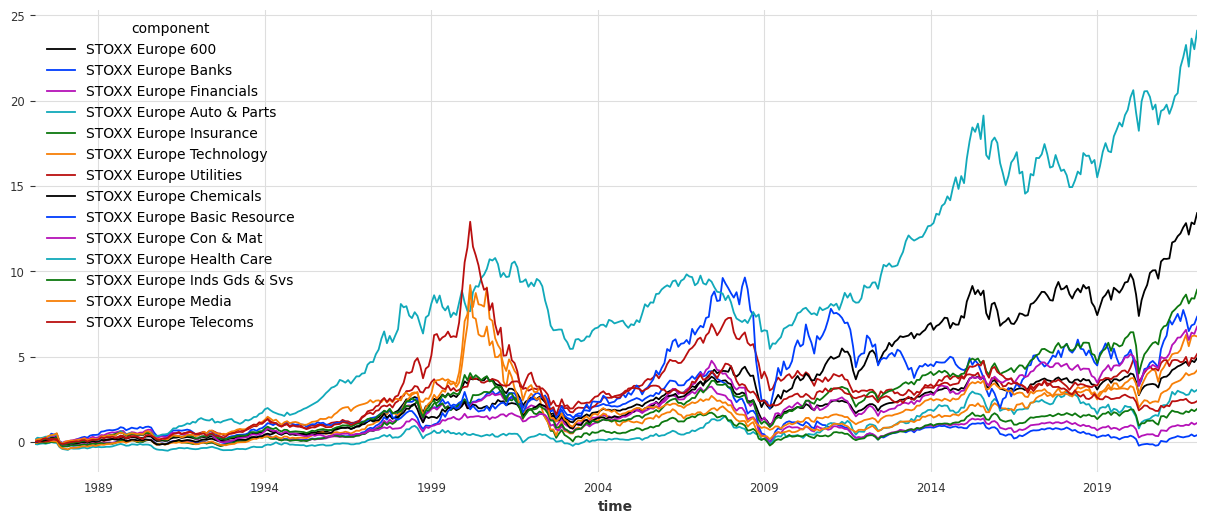

In [9]:
#from io import BytesIO
# compute the cumulative monthly returns
cum_returns = (1 + returns).cumprod() - 1

# store the cum_returns to use it in another notebook
%store cum_returns

# plot the cumulative returns
fig, ax = plt.subplots(figsize=(15, 6))
cum_returns.plot(ax=ax)

# convert the plot to a numpy array
fig.canvas.draw()
image_array = np.array(fig.canvas.renderer.buffer_rgba())

# log the plot to wandb
wandb.log({'Cumulative returns of all indices': wandb.Image(image_array)})

In [10]:
# to use the Darts models, we need to convert the data to a Darts TimeSeries
cum_returns = TimeSeries.from_dataframe(df = cum_returns,time_col= 0, fill_missing_dates=True)

In [11]:
# get the length of the time series
#len(cum_returns)

420

In [12]:
# show the average cumulative monthly return for all assets
#average_returns = cum_returns.last_values().mean()
#average_returns

# Aufbau und Struktur Methoden

Nachdem wir nun die allgemeinen Basics gelegt haben, sprich, die kumulativen returns ermittelt  und das richtige Objekt-Format (Darts TimeSeries) implementiert haben, können wir im nächsten Schritt die zu replizierenden Modelle aufbauen.

Struktur:
1. Shrinkage Methods
2. Dimensionality reduction methods
3. Nonlinear ML methods
4. Combination ML models

## Shrinkage methods:

Darts bietet wie erwähnt standardisierte Modelle an, in denen dann wie von mir verwendet, Sklearn-Methoden als Parameter eingebaut werden können.

Zunächst wurde den verwendeten Parametern keine tiefere Beachtung geschenkt, um vorerst lediglich die Modelle strukturiert aufzubauen. Mittlerweile konnte ich bereits die Hyperparameter tunen, weshalb bereits die optimierten Parameter verwendet wurden. Zudem findet eine Performance-Bewertung mittels MAPE, R2, MASE und MSE statt.

In [13]:
# split the data into training and test set, use 80% for training
train, test = cum_returns.split_after(0.8)

### Linear Regression

Best hyperparameter already used.

In [14]:
# linear regression model
linear_regression = LinearRegressionModel(
    lags=1
    ) # output chunks standard is 1
linear_regression.fit(series=train)
linear_forecast = linear_regression.predict(len(test))

%store linear_forecast

Stored 'linear_forecast' (TimeSeries)


In [15]:
# print mape, r2 score, mase, mse
print('The linear regression model has the following performance:')
print('MAPE: ', mape(test, linear_forecast))
print('R2 score: ', r2_score(test, linear_forecast))
print('MASE: ', mase(test, linear_forecast, train))
print('MSE: ', mse(test, linear_forecast))

The linear regression model has the following performance:
MAPE:  45.6910638145044
R2 score:  -2.2957597761969004
MASE:  8.323047402392989
MSE:  2.806474889968858


In [16]:
#mean_return_lm = linear_forecast.last_values().mean()
#mean_return_lm

### Ridge Regression

Best hyperparameter already used.

In [17]:
# ridge regression model
ridge_regression = RegressionModel(lags=10, output_chunk_length=1, model=sklearn.linear_model.Ridge(alpha=0.2))
ridge_regression.fit(train)
ridge_forecast = ridge_regression.predict(len(test))

%store ridge_forecast

Stored 'ridge_forecast' (TimeSeries)


In [18]:
# print mape, r2 score, mase, mse
print('The ridge regression model has the following performance:')
print('MAPE: ', mape(test, ridge_forecast))
print('R2 score: ', r2_score(test, ridge_forecast))
print('MASE: ', mase(test, ridge_forecast, train))
print('MSE: ', mse(test, ridge_forecast))

The ridge regression model has the following performance:
MAPE:  41.55802669199635
R2 score:  -5.068838539421969
MASE:  9.627630394393538
MSE:  4.725884525738499


In [19]:
#mean_return_rr = ridge_forecast.last_values().mean()
#mean_return_rr

### Lasso Regression

Best hyperparameter already used.

In [20]:
# lasso regression model
lasso_regression = RegressionModel(lags=1, output_chunk_length=1, model=sklearn.linear_model.Lasso(alpha=0))
lasso_regression.fit(train)
lasso_forecast = lasso_regression.predict(len(test))

%store lasso_forecast

Stored 'lasso_forecast' (TimeSeries)


In [21]:
# print mape, r2 score, mase, mse
print('The lasso regression model has the following performance:')
print('MAPE: ', mape(test, lasso_forecast))
print('R2 score: ', r2_score(test, lasso_forecast))
print('MASE: ', mase(test, lasso_forecast, train))
print('MSE: ', mse(test, lasso_forecast))

The lasso regression model has the following performance:
MAPE:  47.254194805064294
R2 score:  -2.2771490522630278
MASE:  8.436662088188536
MSE:  2.908666702658795


In [22]:
#mean_return_lr = lasso_forecast.last_values().mean()
#mean_return_lr

### Elastic Net

Best hyperparameter already used.

In [23]:
# elastic net regression model
elastic_net_regression = RegressionModel(lags=1, output_chunk_length=1, model=sklearn.linear_model.ElasticNet(alpha=0))
elastic_net_regression.fit(train)
elastic_net_forecast = elastic_net_regression.predict(len(test))

%store elastic_net_forecast

Stored 'elastic_net_forecast' (TimeSeries)


In [24]:
# print mape, r2 score, mase, mse
print('The elastic net regression model has the following performance:')
print('MAPE: ', mape(test, elastic_net_forecast))
print('R2 score: ', r2_score(test, elastic_net_forecast))
print('MASE: ', mase(test, elastic_net_forecast, train))
print('MSE: ', mse(test, elastic_net_forecast))

The elastic net regression model has the following performance:
MAPE:  47.254194805064294
R2 score:  -2.2771490522630278
MASE:  8.436662088188536
MSE:  2.908666702658795


In [25]:
#mean_return_el = elastic_net_forecast.last_values().mean()
#mean_return_el

### Bridge Regression

Best hyperparameter already used.

In [26]:
# bridge regression model
bridge_regression = RegressionModel(lags=1, output_chunk_length=1, model=sklearn.linear_model.LassoLarsCV(cv=3))
bridge_regression.fit(train)
bridge_forecast = bridge_regression.predict(len(test))

%store bridge_forecast

Stored 'bridge_forecast' (TimeSeries)


In [27]:
# print mape, r2 score, mase, mse
print('The bridge regression model has the following performance:')
print('MAPE: ', mape(test, bridge_forecast))
print('R2 score: ', r2_score(test, bridge_forecast))
print('MASE: ', mase(test, bridge_forecast, train))
print('MSE: ', mse(test, bridge_forecast))

The bridge regression model has the following performance:
MAPE:  70.75659654914958
R2 score:  -3.003738065650542
MASE:  7.583519175317216
MSE:  2.399472742358792


In [28]:
#mean_return_br = bridge_forecast.last_values().mean()
#mean_return_br

### Plots

Die Plots sind natürlich extrem unübersichtlich, da ich bisher alle gemessenen und vorhergesagten Werte für 14 Variablen plotte. Dies würde ich zu einem späteren Zeitpunkt übersichtlicher gestalten. (Mal abgesehen davon, dass Python mir hier nur 10 von 14 Variablen in die Plots einbezieht). Die Trends sind dennoch deutlich zu erkennen.

Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 

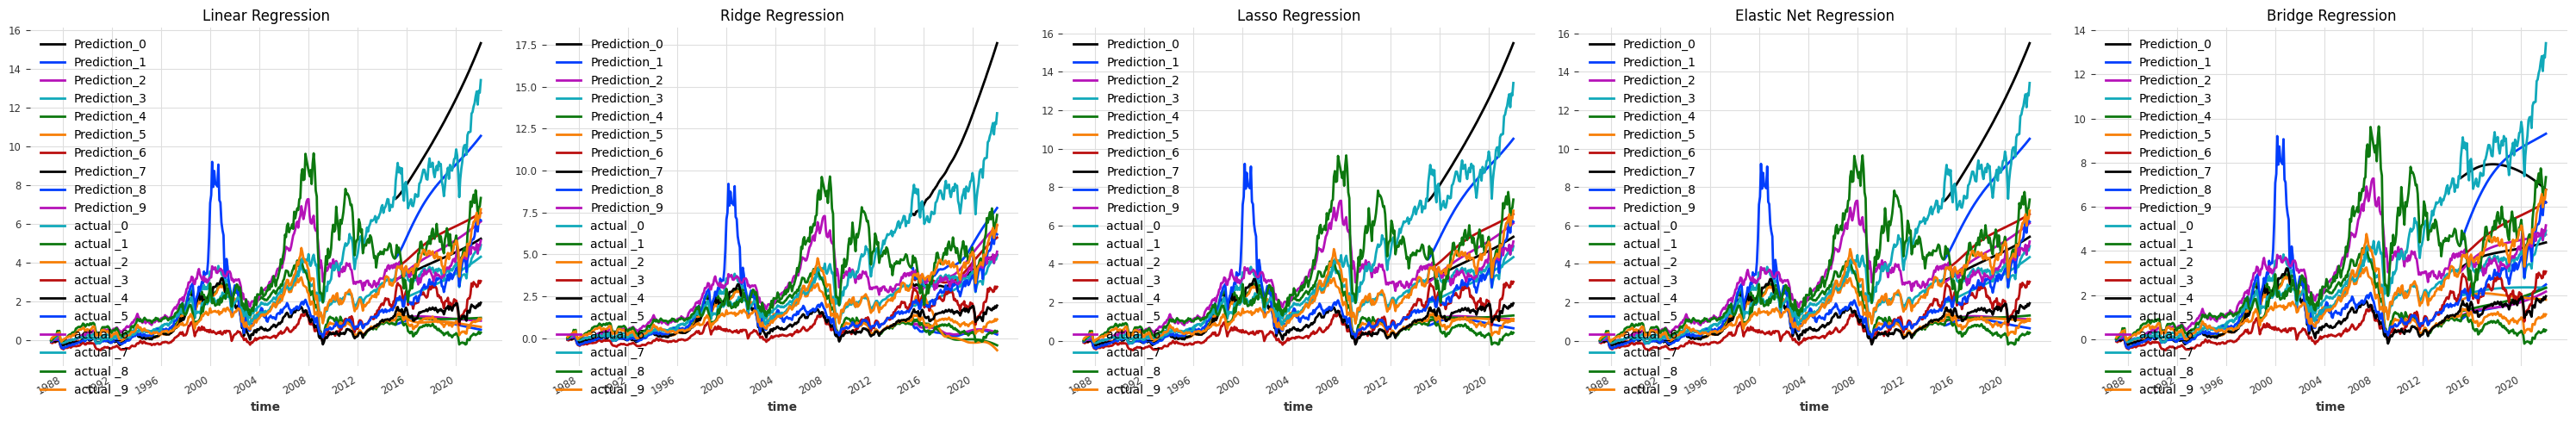

In [29]:
# Plot the predictions
shrinkage_forecasts = {'Linear Regression': linear_forecast,
                       'Ridge Regression': ridge_forecast,
                       'Lasso Regression': lasso_forecast,
                       'Elastic Net Regression': elastic_net_forecast,
                       'Bridge Regression': bridge_forecast}

fig, ax = plt.subplots(1, 5, figsize=(30, 5))
ax = ax.flatten()

for i, (name, forecast) in enumerate(shrinkage_forecasts.items()):
    forecast.plot(label='Prediction', ax=ax[i])
    cum_returns.plot(label='actual ', ax=ax[i])
    ax[i].legend()
    ax[i].set_title(name)

plt.tight_layout()

# convert the plot to a numpy array
fig.canvas.draw()
image_array = np.array(fig.canvas.renderer.buffer_rgba())

# log the plot to wandb
wandb.log({'Shrinkage methods': wandb.Image(image_array)})

## Dimensionality reduction methods

### PLS Regression

In [30]:
# pls regression model
pls_regression = RegressionModel(lags=58, output_chunk_length=1, model= sklearn.cross_decomposition.PLSRegression(n_components=4))
pls_regression.fit(train)
pls_forecast = pls_regression.predict(len(test))

%store pls_forecast

Stored 'pls_forecast' (TimeSeries)


In [31]:
# print mape, r2 score, mase, mse
print('The pls regression model has the following performance:')
print('MAPE: ', mape(test, pls_forecast))
print('R2 score: ', r2_score(test, pls_forecast))
print('MASE: ', mase(test, pls_forecast, train))
print('MSE: ', mse(test, pls_forecast))

The pls regression model has the following performance:
MAPE:  32.958365480549126
R2 score:  -2.8965094627620642
MASE:  9.061195263858792
MSE:  3.848061887338684


In [32]:
#mean_return_pls = pls_forecast.last_values().mean()
#mean_return_pls

### PLS Canonical

In [33]:
# pls canonical regression model
pls_canonical = RegressionModel(lags=1, output_chunk_length=1, model= sklearn.cross_decomposition.PLSCanonical(n_components=3))
pls_canonical.fit(train)
pls_canonical_forecast = pls_canonical.predict(len(test))

%store pls_canonical_forecast

Stored 'pls_canonical_forecast' (TimeSeries)


In [34]:
# print mape, r2 score, mase, mse
print('The pls canonical regression model has the following performance:')
print('MAPE: ', mape(test, pls_canonical_forecast))
print('R2 score: ', r2_score(test, pls_canonical_forecast))
print('MASE: ', mase(test, pls_canonical_forecast, train))
print('MSE: ', mse(test, pls_canonical_forecast))

The pls canonical regression model has the following performance:
MAPE:  37.470971689130295
R2 score:  -4.773536396459083
MASE:  7.390673819796626
MSE:  2.7788201122553096


In [35]:
#mean_return_can = pls_canonical_forecast.last_values().mean()
#mean_return_can

### CCA

In [36]:
# cca regression model
cca = RegressionModel(lags=1, output_chunk_length=1, model= sklearn.cross_decomposition.CCA(n_components=1))
cca.fit(train)
cca_forecast = cca.predict(len(test))

%store cca_forecast

Stored 'cca_forecast' (TimeSeries)


In [37]:
# print mape, r2 score, mase, mse
print('The cca regression model has the following performance:')
print('MAPE: ', mape(test, cca_forecast))
print('R2 score: ', r2_score(test, cca_forecast))
print('MASE: ', mase(test, cca_forecast, train))
print('MSE: ', mse(test, cca_forecast))

The cca regression model has the following performance:
MAPE:  88.61602341891123
R2 score:  -5.533738481763187
MASE:  9.99842821577712
MSE:  3.5796015503866454


In [38]:
#mean_return_cca = cca_forecast.last_values().mean()
#mean_return_cca

### Plots

Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 

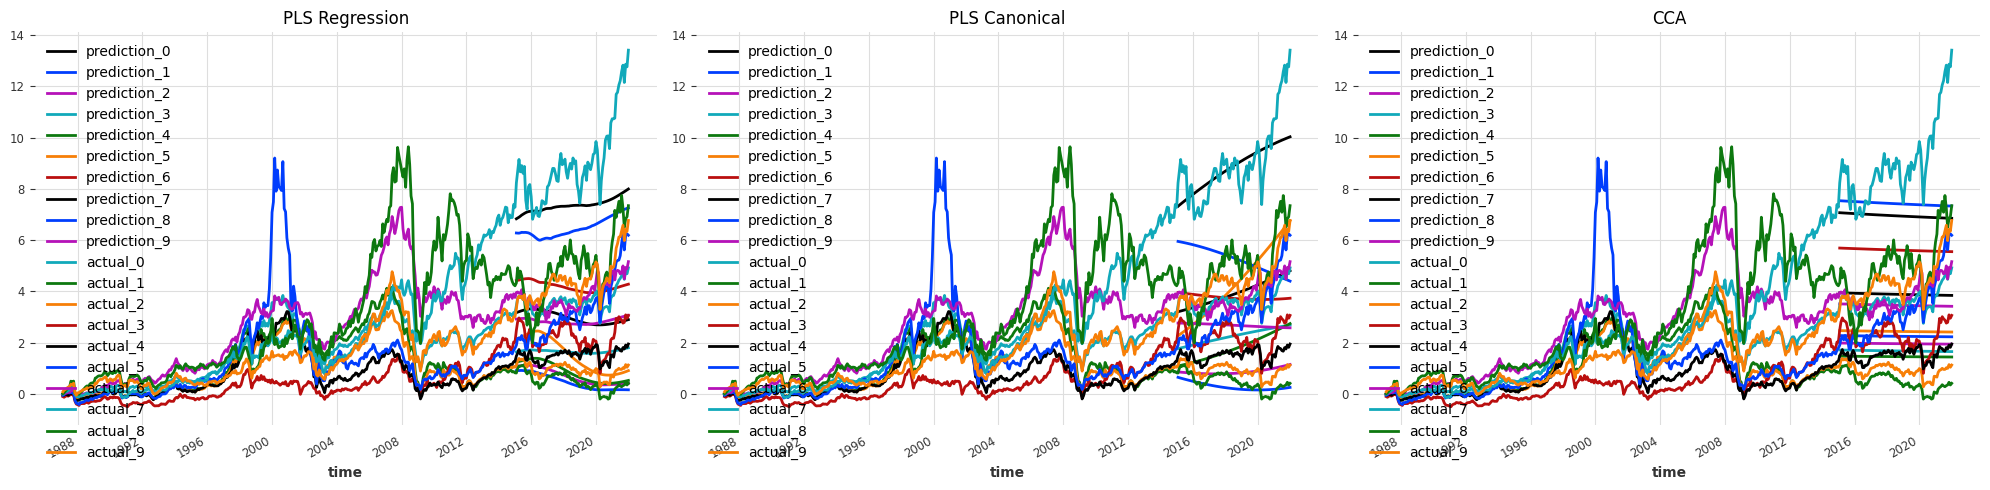

In [39]:
# Plot the predictions
dimensionality_forecasts = {'PLS Regression': pls_forecast,
                            'PLS Canonical': pls_canonical_forecast,
                            'CCA': cca_forecast}

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax = ax.flatten()

for i, (name, forecast) in enumerate(dimensionality_forecasts.items()):
    forecast.plot(label='prediction', ax=ax[i])
    cum_returns.plot(label='actual', ax=ax[i])
    ax[i].legend()
    ax[i].set_title(name)

plt.tight_layout()

# convert the plot to a numpy array
fig.canvas.draw()
image_array = np.array(fig.canvas.renderer.buffer_rgba())

# log the plot to wandb
wandb.log({'Dimensionality reduction methods': wandb.Image(image_array)})

## Nonlinear ML methods

### Random Forest

In [40]:
# random forest model
random_forest = RandomForest(lags=76, output_chunk_length=1, n_estimators=2)
random_forest.fit(train)
random_forest_forecast = random_forest.predict(len(test))

%store random_forest_forecast

Stored 'random_forest_forecast' (TimeSeries)


In [41]:
# print mape, r2 score, mase, mse
print('The random forest model has the following performance:')
print('MAPE: ', mape(test, random_forest_forecast))
print('R2 score: ', r2_score(test, random_forest_forecast))
print('MASE: ', mase(test, random_forest_forecast, train))
print('MSE: ', mse(test, random_forest_forecast))

The random forest model has the following performance:
MAPE:  41.20023504776001
R2 score:  -4.304156444021046
MASE:  11.204114931899047
MSE:  6.4097546623878054


In [42]:
#mean_return_rf = random_forest_forecast.last_values().mean()
#mean_return_rf

### Gradient Boosting Regressor

In [43]:
# gradient boosting model
gb_boosting = RegressionModel(lags=14, output_chunk_length=1, 
                              model=GradientBoostingRegressor(n_estimators=5, learning_rate=0.5, max_depth=4, random_state=0))
gb_boosting.fit(train)
gb_boosting_forecast = gb_boosting.predict(len(test))

%store gb_boosting_forecast

Stored 'gb_boosting_forecast' (TimeSeries)


In [44]:
# print mape, r2 score, mase, mse
print('The gradient boosting model has the following performance:')
print('MAPE: ', mape(test, gb_boosting_forecast))
print('R2 score: ', r2_score(test, gb_boosting_forecast))
print('MASE: ', mase(test, gb_boosting_forecast, train))
print('MSE: ', mse(test, gb_boosting_forecast))

The gradient boosting model has the following performance:
MAPE:  29.33743364426016
R2 score:  -1.3299686732521825
MASE:  7.676619932079913
MSE:  2.5992532826493466


In [45]:
#mean_return_gb = gb_boosting_forecast.last_values().mean()
#mean_return_gb

### Ada Boosting Regressor

In [46]:
# ada boosting model
ada_boosting = RegressionModel(lags=4, output_chunk_length=1,
                                 model=sklearn.ensemble.AdaBoostRegressor(n_estimators=4, random_state=0))
ada_boosting.fit(train)
ada_boosting_forecast = ada_boosting.predict(len(test))

%store ada_boosting_forecast

Stored 'ada_boosting_forecast' (TimeSeries)


In [47]:
# print mape, r2 score, mase, mse
print('The ada boosting model has the following performance:')
print('MAPE: ', mape(test, ada_boosting_forecast))
print('R2 score: ', r2_score(test, ada_boosting_forecast))
print('MASE: ', mase(test, ada_boosting_forecast, train))
print('MSE: ', mse(test, ada_boosting_forecast))

The ada boosting model has the following performance:
MAPE:  35.04555207672215
R2 score:  -1.3413762570278058
MASE:  7.840344600183127
MSE:  2.936764241739013


In [48]:
#mean_return_adab = ada_boosting_forecast.last_values().mean()
#mean_return_adab

### Extra Trees Regressor

In [49]:
# extra tree regression model
extra_tree = RegressionModel(lags=45, output_chunk_length=1,
                                    model=sklearn.ensemble.ExtraTreesRegressor(n_estimators=5, max_depth=4, min_samples_split=3, random_state=0))
extra_tree.fit(train)
extra_tree_forecast = extra_tree.predict(len(test))

%store extra_tree_forecast

Stored 'extra_tree_forecast' (TimeSeries)


In [50]:
# print mape, r2 score, mase, mse
print('The extra tree regression model has the following performance:')
print('MAPE: ', mape(test, extra_tree_forecast))
print('R2 score: ', r2_score(test, extra_tree_forecast))
print('MASE: ', mase(test, extra_tree_forecast, train))
print('MSE: ', mse(test, extra_tree_forecast))

The extra tree regression model has the following performance:
MAPE:  43.029890328395155
R2 score:  -2.2712398671384832
MASE:  9.298961084274667
MSE:  4.021378362793266


In [51]:
#mean_return_et = extra_tree_forecast.last_values().mean()
#mean_return_et

### Support Vector Regression

In [52]:
# support vector regression model
svr = RegressionModel(lags=1, output_chunk_length=1,
                                model=sklearn.svm.SVR(kernel='rbf', C=1e3, gamma=0.1))
svr.fit(train)
svr_forecast = svr.predict(len(test))

%store svr_forecast

Stored 'svr_forecast' (TimeSeries)


In [53]:
# print mape, r2 score, mase, mse
print('The support vector regression model has the following performance:')
print('MAPE: ', mape(test, svr_forecast))
print('R2 score: ', r2_score(test, svr_forecast))
print('MASE: ', mase(test, svr_forecast, train))
print('MSE: ', mse(test, svr_forecast))

The support vector regression model has the following performance:
MAPE:  43.55229666872609
R2 score:  -1.663160512175679
MASE:  8.151721131851815
MSE:  2.9512734730626744


In [54]:
#mean_return_sv = svr_forecast.last_values().mean()
#mean_return_sv

### Plots

Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 

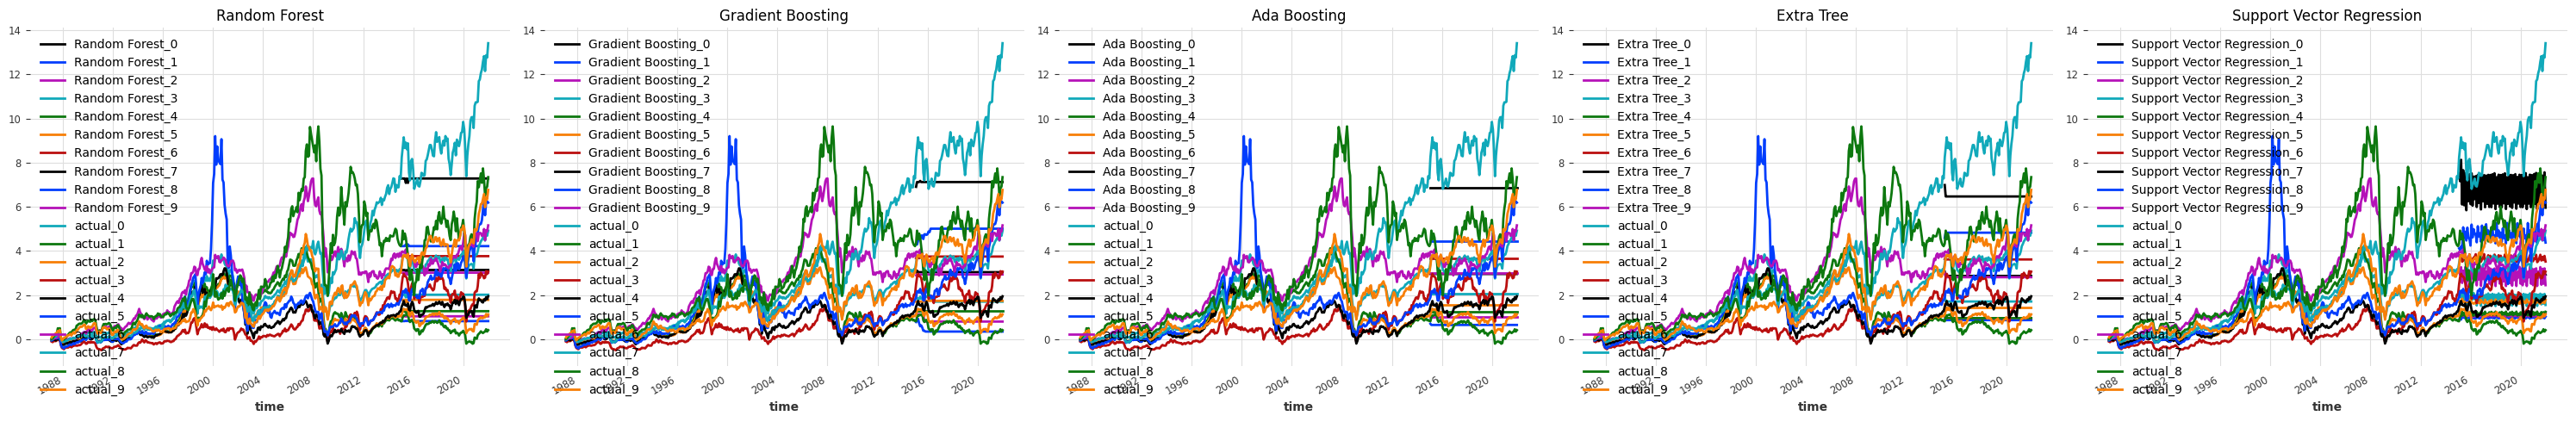

In [55]:
nonlinear_ML_forecasts = {'Random Forest': random_forest_forecast,
                          'Gradient Boosting': gb_boosting_forecast,
                          'Ada Boosting': ada_boosting_forecast,
                          'Extra Tree': extra_tree_forecast,
                          'Support Vector Regression': svr_forecast}

fig, ax = plt.subplots(1, 5, figsize=(30, 5))
ax = ax.flatten()

for i, (name, forecast) in enumerate(nonlinear_ML_forecasts.items()):
    forecast.plot(label=name, ax=ax[i])
    cum_returns.plot(label='actual', ax=ax[i])
    ax[i].legend()
    ax[i].set_title(name)
    
plt.tight_layout()

# convert the plot to a numpy array
fig.canvas.draw()
image_array = np.array(fig.canvas.renderer.buffer_rgba())

# log the plot to wandb
wandb.log({'Nonlinear ML methods': wandb.Image(image_array)})

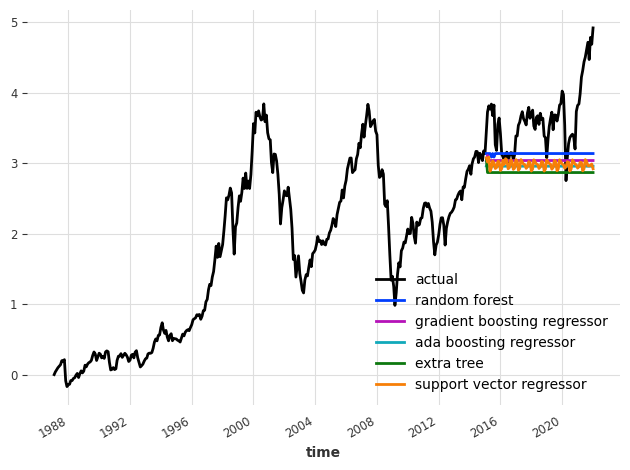

In [56]:
# plot only the outcome of the benchmark
cum_returns["STOXX Europe 600"].plot(label='actual')
random_forest_forecast["STOXX Europe 600"].plot(label="random forest")
gb_boosting_forecast["STOXX Europe 600"].plot(label="gradient boosting regressor")
ada_boosting_forecast["STOXX Europe 600"].plot(label="ada boosting regressor")
extra_tree_forecast["STOXX Europe 600"].plot(label="extra tree")
svr_forecast["STOXX Europe 600"].plot(label="support vector regressor")
    
plt.tight_layout()

# convert the plot to a numpy array
fig.canvas.draw()
image_array = np.array(fig.canvas.renderer.buffer_rgba())

# log the plot to wandb
wandb.log({'Nonlinear ML methods for bechmark': wandb.Image(image_array)})

## Combination ML methods

### Combination Shrinkage

In [ ]:
# ensemble of regression models
shrinkage_ensemble = [LinearRegressionModel(lags=1, output_chunk_length=1),
                      RegressionModel(lags=10, output_chunk_length=1, model=sklearn.linear_model.Ridge(alpha=0.2)),
                       RegressionModel(lags=1, output_chunk_length=1, model=sklearn.linear_model.Lasso(alpha=0)),
                       RegressionModel(lags=1, output_chunk_length=1, model=sklearn.linear_model.ElasticNet(alpha=0)),
                       RegressionModel(lags=1, output_chunk_length=1, model=sklearn.linear_model.LassoLarsCV(cv=3))]

In [ ]:
shrinkage_ensemble_model = RegressionEnsembleModel(forecasting_models=shrinkage_ensemble, regression_train_n_points=100)
shrinkage_ensemble_model.fit(train)
shrinkage_ensemble_forecast = shrinkage_ensemble_model.predict(len(test))

In [ ]:
# print mape, r2 score, mase, mse
#print('The shrinkage ensemble model has the following performance:')
#print('MAPE: ', mape(test, shrinkage_ensemble_forecast))
#print('R2 score: ', r2_score(test, shrinkage_ensemble_forecast))
#print('MASE: ', mase(test, shrinkage_ensemble_forecast, train))
#print('MSE: ', mse(test, shrinkage_ensemble_forecast))

In [ ]:
#mean_return_c_shrinkage = shrinkage_ensemble_forecast.last_values().mean()
#mean_return_c_shrinkage

### Combination Dimensionality Reduction

In [ ]:
# ensemble of dimsenionality reduction models
dim_ensemble = [RegressionModel(lags=1, output_chunk_length=1, model=sklearn.cross_decomposition.PLSRegression(n_components=1)),
                RegressionModel(lags=1, output_chunk_length=1, model=sklearn.cross_decomposition.PLSCanonical(n_components=1)),
                RegressionModel(lags=1, output_chunk_length=1, model=sklearn.cross_decomposition.CCA(n_components=1))]

In [ ]:
dim_ensemble_model = RegressionEnsembleModel(forecasting_models=dim_ensemble, regression_train_n_points=100)
dim_ensemble_model.fit(train)
dim_ensemble_forecast = dim_ensemble_model.predict(len(test))

In [ ]:
# print mape, r2 score, mase, mse
print('The dimensionality reduction ensemble model has the following performance:')
print('MAPE: ', mape(test, dim_ensemble_forecast))
print('R2 score: ', r2_score(test, dim_ensemble_forecast))
print('MASE: ', mase(test, dim_ensemble_forecast, train))
print('MSE: ', mse(test, dim_ensemble_forecast))

The dimensionality reduction ensemble model has the following performance:
MAPE:  100.0
R2 score:  -31.48693883109621
MASE:  32.09811514977248
MSE:  39.693017331483404


In [ ]:
mean_return_c_dim_ensemble = dim_ensemble_forecast.last_values().mean()
mean_return_c_dim_ensemble

1.491229483401007e-22

### Combination Nonlinear ML

In [ ]:
# ensemble of nonlinear models
nonlinear_ensemble = [RandomForest(lags=76, output_chunk_length=1, n_estimators=2),
                        RegressionModel(lags=100, output_chunk_length=1, model=GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0)),
                        RegressionModel(lags=1, output_chunk_length=1, model=sklearn.ensemble.AdaBoostRegressor(n_estimators=100, random_state=0)),
                        RegressionModel(lags=1, output_chunk_length=1, model=sklearn.ensemble.ExtraTreesRegressor(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)),
                        RegressionModel(lags=1, output_chunk_length=1, model=sklearn.svm.SVR(kernel='rbf', C=1e3, gamma=0.1))]

In [ ]:
nonlinear_ensemble_model = RegressionEnsembleModel(forecasting_models=nonlinear_ensemble, regression_train_n_points=100)
nonlinear_ensemble_model.fit(train)
nonlinear_ensemble_forecast = nonlinear_ensemble_model.predict(len(test))

In [ ]:
# print mape, r2 score, mase, mse
#print('The nonlinear ensemble model has the following performance:')
#print('MAPE: ', mape(test, nonlinear_ensemble_forecast))
#print('R2 score: ', r2_score(test, nonlinear_ensemble_forecast))
#print('MASE: ', mase(test, nonlinear_ensemble_forecast, train))
#print('MSE: ', mse(test, nonlinear_ensemble_forecast))

In [ ]:
#mean_return_c_nonlinear = nonlinear_ensemble_forecast.last_values().mean()
#mean_return_c_nonlinear

### Plots

Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 

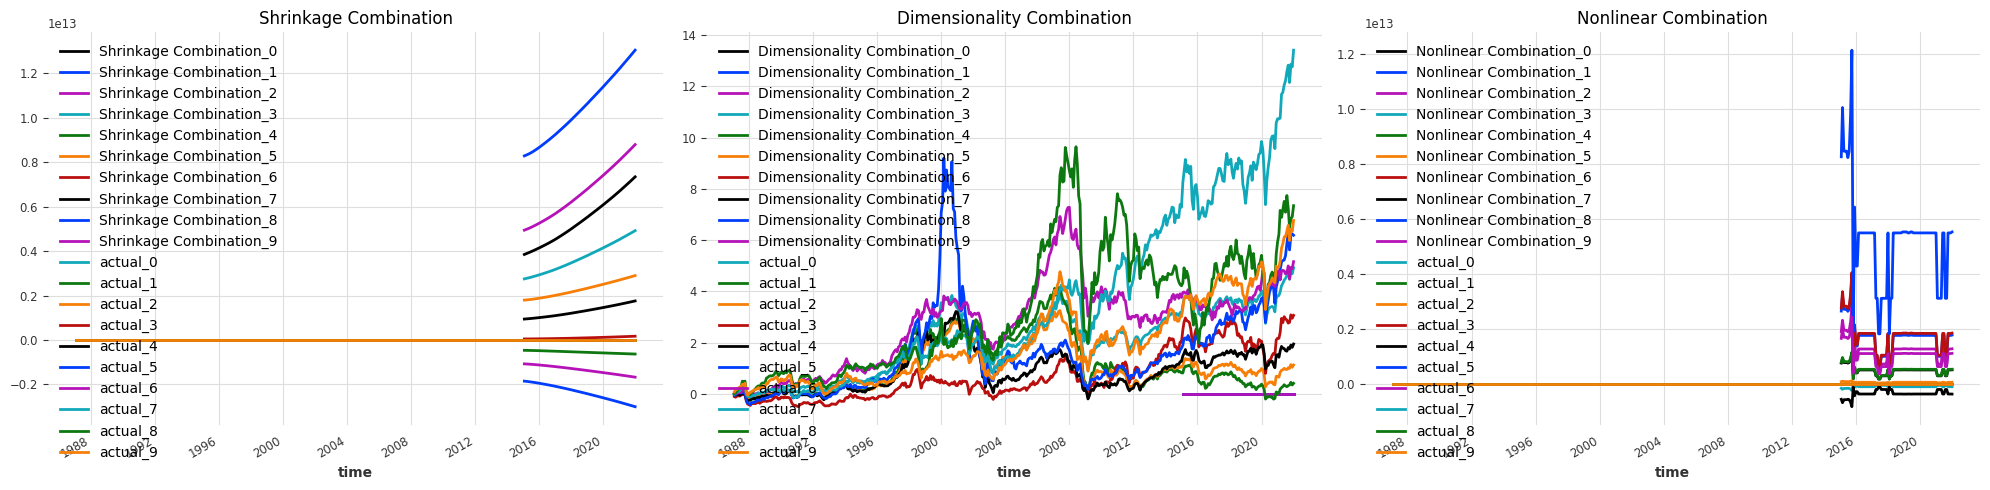

In [ ]:
combination_forecasts = {'Shrinkage Combination': shrinkage_ensemble_forecast,
                         'Dimensionality Combination': dim_ensemble_forecast,
                         'Nonlinear Combination': nonlinear_ensemble_forecast}

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax = ax.flatten()

for i, (name, forecast) in enumerate(combination_forecasts.items()):
    forecast.plot(label=name, ax=ax[i])
    cum_returns.plot(label='actual', ax=ax[i])
    ax[i].legend()
    ax[i].set_title(name)
    
plt.tight_layout()

# convert the plot to a numpy array
fig.canvas.draw()
image_array = np.array(fig.canvas.renderer.buffer_rgba())

# log the plot to wandb
wandb.log({'Combination ML methods': wandb.Image(image_array)})

## Auswertung

Nachdem sowohl die Mittelwerte der jeweiligen Portfolios im Vergleich zum Mittelwert der kumulativen Returns des Ursprungportfolios eher schlecht abgeschnitten haben, ist im folgenden Schritt das Hyperparameter Tuning logisch. Zudem ist offensichtlich in der Zusammenstellung der Kombinationen ein Fehler, mindestens im Plotting (die einzelnen Plots habe ich geprüft und legen keine Fehler in der Berechnung offen).

Hyperparameter Tuning ist ein Prozess (bzw. ein Optimierungsproblem), bei dem die Leistung eines maschinellen Lernmodells verbessert wird, indem verschiedene Kombinationen von Hyperparametern ausprobiert werden, um die besten Einstellungen für das Modell zu finden.

# Hyperparameter Tuning .gridSearch()

Darts bietet hierfür die .gridsearch() Funktion an. Jedes Prognosemodell in Darts bietet eine gridsearch()-Methode für die grundlegende Hyperparametersuche. Diese Methode ist auf sehr einfache Fälle mit sehr wenigen Hyperparametern beschränkt und arbeitet nur mit einer einzigen Zeitreihe.
Somit bietet sich in unserem Fall nicht die Nutzung der .gridearch() Funktion an, da wir mit mehreren Zeitreihen arbeiten.

Überlegen wir uns nochmal welche Paramter überhaupt in der Funktion für zunächst die lineare Regression stecken und planen basierend auf diesen Informationen und den Angeboten in Darts eine Optimierungsmethode für Hyperparameter:

- lags=None: gibt an, wie viele vergangene Zeitpunkte in die Vorhersage eines bestimmten Zeitpunkts einbezogen werden sollen
- lags_past_covariates=None: Eine Liste von Verzögerungen für vergangene Kovariablen, die als Eingabe für das Modell verwendet werden sollen. Kovariablen sind zusätzliche Variablen, die zur Vorhersage der Zielvariable beitragen können.
- lags_future_covariates=None: Eine Liste von Verzögerungen für zukünftige Kovariablen, die als Eingabe für das Modell verwendet werden sollen.
- output_chunk_length=1: gibt an, wie viele zukünftige Zeitpunkte in einem einzigen Vorhersageschritt vorhergesagt werden sollen
- add_encoders=None: Encoders sind Funktionen, die Kovariablen in eine numerische Darstellung umwandeln, die als Eingabe für das Modell verwendet werden kann
- likelihood=None: Standardwerte sind None, was bedeutet, dass die Normalverteilung als Standard-Likelihood-Funktion verwendet wird.
- quantiles=None: Eine Liste von Quantilen, die zur Berechnung von Quantilsregressionen verwendet werden sollen
- random_state=None: Seed, der für die Initialisierung der Modellparameter verwendet werden soll.
- multi_models=True: Boolean, der angibt, ob das Modell für jede Spalte in der Eingabe eine separate lineare Regression durchführen soll
- use_static_covariates=True: Boolean, der angibt, ob statische Kovariablen in das Modell einbezogen werden sollen. Statische Kovariablen sind Kovariablen, die für jeden Zeitpunkt in der Zeitreihe gleich bleiben.

Folgende Parameter sind mEn für die ersten Schritte von Relevanz: lags, output_chunk_length = 1. Wichtig ist somit vorerst nur, wie viele vergangene Monatswerte in die Vorhersage einbezogen werden. Eine Vorhersage von einem Zukunftszeitpunkt ist vorerst ausreichend.

Use Linear Regression as benchmark and test

LinearRegressionModel(lags=None, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

classmethod gridsearch(parameters, series, past_covariates=None, future_covariates=None, forecast_horizon=None, stride=1, start=0.5, last_points_only=False, show_warnings=True, val_series=None, use_fitted_values=False, metric=<function mape>, reduction=<function mean>, verbose=False, n_jobs=1, n_random_samples=None)


past covariates in the linear regression model refer to variables that are used as additional inputs in addition to the past values of the target time series for predicting its future values. These variables can be other time series that have a relationship with the target time series. The lags_past_covariates parameter in the LinearRegressionModel constructor is used to specify the number of time steps in the past of the past covariates to be used in the model. The past covariates should also be provided as a TimeSeries object with the same frequency as the target time series.

In [ ]:
# print the maximum number of lags that is possible
print('The maximum number of lags that is possible is: ', len(train['STOXX Europe 600']))

The maximum number of lags that is possible is:  336


## Hyperparameter Shrinkage Methods

### Tuning Linear Regression

In [61]:
hyperparameter_linear = {
    "lags": list(range(1, 336))
}

In [57]:
# linear regression model with 1 lag of STOXX Europe 600
linear_model_1 = LinearRegressionModel(lags=1, output_chunk_length=1)
linear_model_1.fit(train)
linear_forecast_1 = linear_model_1.predict(len(test))

# linear regression model with 316 lags of STOXX Europe 600
linear_model_316 = LinearRegressionModel(lags=316, output_chunk_length=1)
linear_model_316.fit(train)
linear_forecast_316 = linear_model_316.predict(len(test))

# linear regression model with 317 lags of STOXX Europe 600
linear_model_317 = LinearRegressionModel(lags=317, output_chunk_length=1)
linear_model_317.fit(train)
linear_forecast_317 = linear_model_317.predict(len(test))

# linear regression model with 335 lags of STOXX Europe 600
linear_model_335 = LinearRegressionModel(lags=335, output_chunk_length=1)
linear_model_335.fit(train) # ['STOXX Europe 600']
linear_forecast_335 = linear_model_335.predict(len(test))

%store linear_forecast_1
%store linear_forecast_316
%store linear_forecast_317
%store linear_forecast_335

Stored 'linear_forecast_1' (TimeSeries)
Stored 'linear_forecast_316' (TimeSeries)
Stored 'linear_forecast_317' (TimeSeries)
Stored 'linear_forecast_335' (TimeSeries)


Beyond that I tested other lags with the following outcome:

1 lag - MAPE: 14.53%

10 lags - MAPE: 24.64%,
20 lags - MAPE: 26.66%,
100 lags - MAPE: 30.66%,
300 lags - MAPE: 21.72%,

312 lags - MAPE: 19.45%,
313 lags - MAPE: 17.87%,
314 lags - MAPE: 20.28%,
315 lags - MAPE: 17.69%,
316 lags - MAPE: 16.82%,
317 lags - MAPE: 18.79%,

333 lags - MAPE: 14.01%,
334 lags - MAPE: 13.20%,
335 lags (max) - MAPE: 13.21%


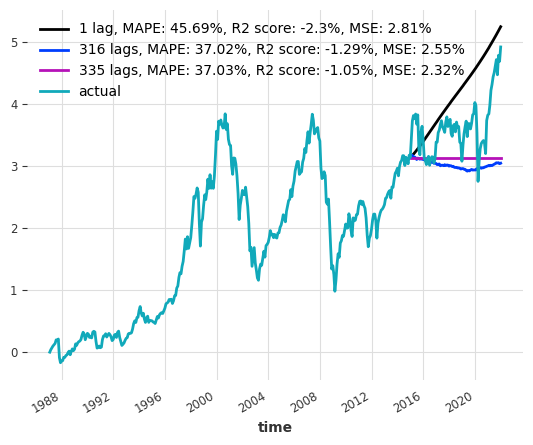

In [58]:
# plot linear forecast with 1, 316 and 335 lags and label with MAPE rounded to 2 decimals and R2 score rounded to 2 decimals and MSE rounded to 2 decimals
linear_forecast_1['STOXX Europe 600'].plot(label='1 lag, MAPE: ' + str(round(mape(test, linear_forecast_1), 2)) + '%, R2 score: ' + str(round(r2_score(test, linear_forecast_1), 2)) + '%, MSE: ' + str(round(mse(test, linear_forecast_1), 2)) + '%')
linear_forecast_316['STOXX Europe 600'].plot(label='316 lags, MAPE: ' + str(round(mape(test, linear_forecast_316), 2)) + '%, R2 score: ' + str(round(r2_score(test, linear_forecast_316), 2)) + '%, MSE: ' + str(round(mse(test, linear_forecast_316), 2)) + '%')
linear_forecast_335['STOXX Europe 600'].plot(label='335 lags, MAPE: ' + str(round(mape(test, linear_forecast_335), 2)) + '%, R2 score: ' + str(round(r2_score(test, linear_forecast_335), 2)) + '%, MSE: ' + str(round(mse(test, linear_forecast_335), 2)) + '%')

# rewrite to see only one line
cum_returns['STOXX Europe 600'].plot(label='actual')

In [66]:
tuning_linear = LinearRegressionModel.gridsearch(
    parameters= hyperparameter_linear,
    series= train, # The target series used as input and target for training.
    val_series= test,
    start= 0.0, # represents the starting point in the time index of series from which predictions will be made to evaluate the model
    #metric= , # function that takes actual and prediction, and returns a float error value
    n_jobs= -1, # setting the parameter to -1 means using all the available cores
    verbose= True # whether to print progress
)

  0%|          | 0/335 [00:00<?, ?it/s]

In [67]:
best_model, best_params = tuning_linear[0], tuning_linear[1]
best_model.model_params

OrderedDict([('lags', 314),
             ('lags_past_covariates', None),
             ('lags_future_covariates', None),
             ('output_chunk_length', 1),
             ('add_encoders', None),
             ('likelihood', None),
             ('quantiles', None),
             ('random_state', None),
             ('multi_models', True),
             ('use_static_covariates', True)])

### Tuning Ridge Regression
How to test this when the model includes another sklearn model.

In [ ]:
hyperparameter_ridge = {
    "lags": list(range(1,336,2)),
    'model': [
        sklearn.linear_model.Ridge(alpha=a) for a in np.arange(0, 1.1, 0.1)
    ]
}

In [69]:
# ridge regression model with 1 lag of STOXX Europe 600
ridge_model_1 = RegressionModel(lags=1, model=sklearn.linear_model.Ridge(alpha=0))
ridge_model_1.fit(train)
ridge_forecast_1 = ridge_model_1.predict(len(test))

# ridge regression model with 316 lags of STOXX Europe 600
ridge_model_316 =RegressionModel(lags=316, model=sklearn.linear_model.Ridge(alpha=0))
ridge_model_316.fit(train)
ridge_forecast_316 = ridge_model_316.predict(len(test))

# ridge regression model with 317 lags of STOXX Europe 600
ridge_model_317 = RegressionModel(lags=317, model=sklearn.linear_model.Ridge(alpha=0))
ridge_model_317.fit(train)
ridge_forecast_317 = ridge_model_317.predict(len(test))

# ridge regression model with 335 lags of STOXX Europe 600
ridge_model_335 = RegressionModel(lags=335, model=sklearn.linear_model.Ridge(alpha=0))
ridge_model_335.fit(train)
ridge_forecast_335 = ridge_model_335.predict(len(test))

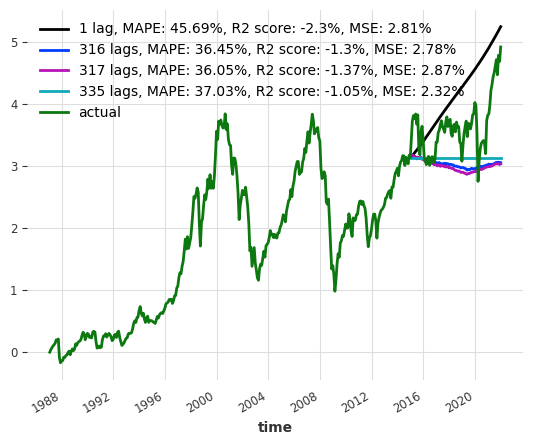

In [ ]:
# plot the ridge forecast with 1, 316, 317 and 335 lags and label with MAPE rounded to 2 decimals and R2 score rounded to 2 decimals and MSE rounded to 2 decimals
ridge_forecast_1['STOXX Europe 600'].plot(label='1 lag, MAPE: ' + str(round(mape(test, ridge_forecast_1), 2)) + '%, R2 score: ' + str(round(r2_score(test, ridge_forecast_1), 2)) + '%, MSE: ' + str(round(mse(test, ridge_forecast_1), 2)) + '%')
ridge_forecast_316['STOXX Europe 600'].plot(label='316 lags, MAPE: ' + str(round(mape(test, ridge_forecast_316), 2)) + '%, R2 score: ' + str(round(r2_score(test, ridge_forecast_316), 2)) + '%, MSE: ' + str(round(mse(test, ridge_forecast_316), 2)) + '%')
ridge_forecast_317['STOXX Europe 600'].plot(label='317 lags, MAPE: ' + str(round(mape(test, ridge_forecast_317), 2)) + '%, R2 score: ' + str(round(r2_score(test, ridge_forecast_317), 2)) + '%, MSE: ' + str(round(mse(test, ridge_forecast_317), 2)) + '%')
ridge_forecast_335['STOXX Europe 600'].plot(label='335 lags, MAPE: ' + str(round(mape(test, ridge_forecast_335), 2)) + '%, R2 score: ' + str(round(r2_score(test, ridge_forecast_335), 2)) + '%, MSE: ' + str(round(mse(test, ridge_forecast_335), 2)) + '%')

# rewrite to see only one line
cum_returns['STOXX Europe 600'].plot(label='actual')

In [ ]:
ridge_regression_tune = RegressionModel(
    lags= hyperparameter_ridge['lags'][0],
    model=sklearn.linear_model.Ridge(0)
)

In [ ]:
tuning_ridge = ridge_regression_tune.gridsearch(
    parameters= hyperparameter_ridge,
    series= train,
    val_series= test,
    start= 0.1,
    metric= mse,
    n_jobs= -1,
    verbose= True
)

  0%|          | 0/1848 [00:00<?, ?it/s]

/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.08156e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=9.26853e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3

In [ ]:
best_model, best_params = tuning_ridge[0], tuning_ridge[1]
best_model.model_params

OrderedDict([('lags', 331),
             ('lags_past_covariates', None),
             ('lags_future_covariates', None),
             ('output_chunk_length', 1),
             ('add_encoders', None),
             ('model', Ridge()),
             ('multi_models', True),
             ('use_static_covariates', True)])

### Tuning Lasso Regression

In [ ]:
hyperparameter_lasso = {
    "lags": list(range(1,336, 2)),
    'model': [
        sklearn.linear_model.Lasso(alpha=a) for a in np.arange(0, 1.1, 0.1)
    ]
}

In [ ]:
# lasso regression model with 1 lag of STOXX Europe 600
lasso_model_1 = RegressionModel(lags=1, model=sklearn.linear_model.Lasso(alpha=0))
lasso_model_1.fit(train)
lasso_forecast_1 = lasso_model_1.predict(len(test))

# lasso regression model with 316 lags of STOXX Europe 600
lasso_model_316 = RegressionModel(lags=316, model=sklearn.linear_model.Lasso(alpha=0))
lasso_model_316.fit(train)
lasso_forecast_316 = lasso_model_316.predict(len(test))

# lasso regression model with 317 lags of STOXX Europe 600
lasso_model_317 = RegressionModel(lags=317, model=sklearn.linear_model.Lasso(alpha=0))
lasso_model_317.fit(train)
lasso_forecast_317 = lasso_model_317.predict(len(test))

# lasso regression model with 335 lags of STOXX Europe 600
lasso_model_335 = RegressionModel(lags=335, model=sklearn.linear_model.Lasso(alpha=0))
lasso_model_335.fit(train)
lasso_forecast_335 = lasso_model_335.predict(len(test))

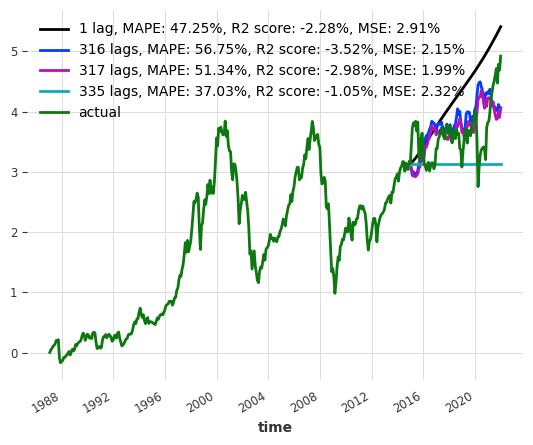

In [ ]:
# plot the lasso forecast with 1, 316, 317 and 335 lags and label with MAPE rounded to 2 decimals and R2 score rounded to 2 decimals and MSE rounded to 2 decimals
lasso_forecast_1['STOXX Europe 600'].plot(label='1 lag, MAPE: ' + str(round(mape(test, lasso_forecast_1), 2)) + '%, R2 score: ' + str(round(r2_score(test, lasso_forecast_1), 2)) + '%, MSE: ' + str(round(mse(test, lasso_forecast_1), 2)) + '%')
lasso_forecast_316['STOXX Europe 600'].plot(label='316 lags, MAPE: ' + str(round(mape(test, lasso_forecast_316), 2)) + '%, R2 score: ' + str(round(r2_score(test, lasso_forecast_316), 2)) + '%, MSE: ' + str(round(mse(test, lasso_forecast_316), 2)) + '%')
lasso_forecast_317['STOXX Europe 600'].plot(label='317 lags, MAPE: ' + str(round(mape(test, lasso_forecast_317), 2)) + '%, R2 score: ' + str(round(r2_score(test, lasso_forecast_317), 2)) + '%, MSE: ' + str(round(mse(test, lasso_forecast_317), 2)) + '%')
lasso_forecast_335['STOXX Europe 600'].plot(label='335 lags, MAPE: ' + str(round(mape(test, lasso_forecast_335), 2)) + '%, R2 score: ' + str(round(r2_score(test, lasso_forecast_335), 2)) + '%, MSE: ' + str(round(mse(test, lasso_forecast_335), 2)) + '%')

# rewrite to see only one line
cum_returns['STOXX Europe 600'].plot(label='actual')

In [ ]:
lasso_regression_tune = RegressionModel(
    lags= hyperparameter_lasso['lags'][0],
    model=sklearn.linear_model.Lasso(0)
)

In [ ]:
tuning_lasso = lasso_regression_tune.gridsearch(
    parameters= hyperparameter_lasso,
    series= train,
    val_series= test,
    start= 0.1,
    metric= mape,
    n_jobs= -1,
    verbose= True
)

  0%|          | 0/1848 [00:00<?, ?it/s]

/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/darts/models/forecasting/regression_model.py:410: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(training_samples, training_labels, **kwargs)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.522e+00, tolerance: 4.405e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fit

In [ ]:
best_model, best_params = tuning_lasso[0], tuning_lasso[1]
best_model.model_params

OrderedDict([('lags', 329),
             ('lags_past_covariates', None),
             ('lags_future_covariates', None),
             ('output_chunk_length', 1),
             ('add_encoders', None),
             ('model', Lasso(alpha=0.0)),
             ('multi_models', True),
             ('use_static_covariates', True)])

### Tuning Elastic Net

In [ ]:
hyperparameter_elastic = {
    "lags": list(range(1,336, 2)),
    'model': [
        sklearn.linear_model.ElasticNet(alpha=a) for a in np.arange(0, 1.1, 0.1)
    ]
}

In [ ]:
# elastic net regression model with 1 lag of STOXX Europe 600
elastic_model_1 = RegressionModel(lags=1, model=sklearn.linear_model.ElasticNet(alpha=0))
elastic_model_1.fit(train)
elastic_forecast_1 = elastic_model_1.predict(len(test))

# elastic net regression model with 316 lags of STOXX Europe 600
elastic_model_316 = RegressionModel(lags=316, model=sklearn.linear_model.ElasticNet(alpha=0))
elastic_model_316.fit(train)
elastic_forecast_316 = elastic_model_316.predict(len(test))

# elastic net regression model with 317 lags of STOXX Europe 600
elastic_model_317 = RegressionModel(lags=317, model=sklearn.linear_model.ElasticNet(alpha=0))
elastic_model_317.fit(train)
elastic_forecast_317 = elastic_model_317.predict(len(test))

# elastic net regression model with 335 lags of STOXX Europe 600
elastic_model_335 = RegressionModel(lags=335, model=sklearn.linear_model.ElasticNet(alpha=0))
elastic_model_335.fit(train)
elastic_forecast_335 = elastic_model_335.predict(len(test))

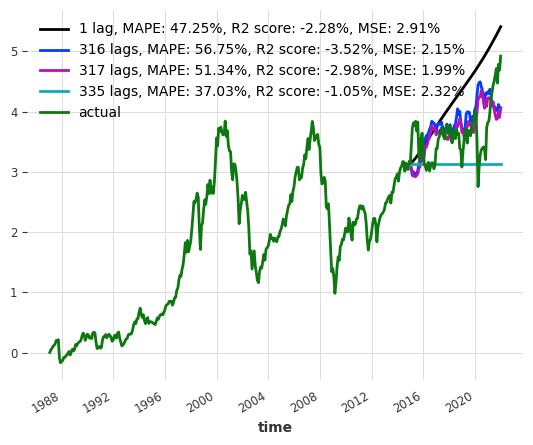

In [ ]:
# plot the elastic net forecast with 1, 316, 317 and 335 lags and label with MAPE rounded to 2 decimals and R2 score rounded to 2 decimals and MSE rounded to 2 decimals
elastic_forecast_1['STOXX Europe 600'].plot(label='1 lag, MAPE: ' + str(round(mape(test, elastic_forecast_1), 2)) + '%, R2 score: ' + str(round(r2_score(test, elastic_forecast_1), 2)) + '%, MSE: ' + str(round(mse(test, elastic_forecast_1), 2)) + '%')
elastic_forecast_316['STOXX Europe 600'].plot(label='316 lags, MAPE: ' + str(round(mape(test, elastic_forecast_316), 2)) + '%, R2 score: ' + str(round(r2_score(test, elastic_forecast_316), 2)) + '%, MSE: ' + str(round(mse(test, elastic_forecast_316), 2)) + '%')
elastic_forecast_317['STOXX Europe 600'].plot(label='317 lags, MAPE: ' + str(round(mape(test, elastic_forecast_317), 2)) + '%, R2 score: ' + str(round(r2_score(test, elastic_forecast_317), 2)) + '%, MSE: ' + str(round(mse(test, elastic_forecast_317), 2)) + '%')
elastic_forecast_335['STOXX Europe 600'].plot(label='335 lags, MAPE: ' + str(round(mape(test, elastic_forecast_335), 2)) + '%, R2 score: ' + str(round(r2_score(test, elastic_forecast_335), 2)) + '%, MSE: ' + str(round(mse(test, elastic_forecast_335), 2)) + '%')

# rewrite to see only one line
cum_returns['STOXX Europe 600'].plot(label='actual')

In [ ]:
elastic_net_tune = RegressionModel(
    lags= hyperparameter_elastic['lags'][0],
    model=sklearn.linear_model.ElasticNet(0)
)

In [ ]:
tuning_elastic_net = elastic_net_tune.gridsearch(
    parameters= hyperparameter_elastic,
    series= train,
    val_series= test,
    start= 0.1,
    metric= mape,
    n_jobs= -1,
    verbose= True
)

  0%|          | 0/1848 [00:00<?, ?it/s]

/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/darts/models/forecasting/regression_model.py:410: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(training_samples, training_labels, **kwargs)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.522e+00, tolerance: 4.405e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fit

In [ ]:
best_model, best_params = tuning_elastic_net[0], tuning_elastic_net[1]
# print the best model parameters
best_model.model_params

OrderedDict([('lags', 329),
             ('lags_past_covariates', None),
             ('lags_future_covariates', None),
             ('output_chunk_length', 1),
             ('add_encoders', None),
             ('model', ElasticNet(alpha=0.0)),
             ('multi_models', True),
             ('use_static_covariates', True)])

### Tuning Bridge Regression

In [ ]:
hyperparameter_bridge = {
    "lags": list(range(1,336, 2)),
    'model': [
        sklearn.linear_model.LassoLarsCV(cv=c, n_jobs=-1) 
        for c in np.arange(2, 13, 1)
    ]
}

In [ ]:
# here bridge then

In [ ]:
# here plotting then

In [ ]:
bridge_regression_tune = RegressionModel(
    lags= hyperparameter_bridge['lags'][0],
    model=sklearn.linear_model.LassoLarsCV(cv=0, n_jobs=-1)
)

In [ ]:
tuning_bridge = bridge_regression_tune.gridsearch(
    parameters= hyperparameter_bridge,
    series= train,
    val_series= test,
    start= 0.1,
    metric= mape,
    n_jobs= -1,
    verbose= True
)

  0%|          | 0/800 [00:00<?, ?it/s]

In [ ]:
best_model, best_params = tuning_bridge[0], tuning_bridge[1]
# print the best model parameters
best_model.model_params

## Hyperparameter Dimensionality Reduction

### Tuning PLS Regression

In [ ]:
hyperparameter_pls = {
    "lags": list(range(317,318,1)),
    'model': [
        sklearn.cross_decomposition.PLSRegression(n_components=n) for n in np.arange(1, 15, 1)
    ]
}

In [71]:
# pls regression model with 1 lag
pls_model_1 = RegressionModel(lags=1, model=sklearn.cross_decomposition.PLSRegression(n_components=5))
pls_model_1.fit(train)
pls_forecast_1 = pls_model_1.predict(len(test))

# pls regression model with 316 lags
pls_model_316 = RegressionModel(lags=316, model=sklearn.cross_decomposition.PLSRegression(n_components=1))
pls_model_316.fit(train)
pls_forecast_316 = pls_model_316.predict(len(test))

# pls regression model with 317 lags
pls_model_317 = RegressionModel(lags=317, model=sklearn.cross_decomposition.PLSRegression(n_components=1))
pls_model_317.fit(train)
pls_forecast_317 = pls_model_317.predict(len(test))

# 335 lags was not possible to run

Influence of the parameter 'n_components' & best performing lags:
- 1 lag  MAPE: "11" - 35.7; MSE: "5" - 2.76

- 316 lags  MAPE: "11" - 35.87; MSE: "1" - 1.64

- 317 lags  MAPE: "12" - 39.91; MSE: "1" - 1.62

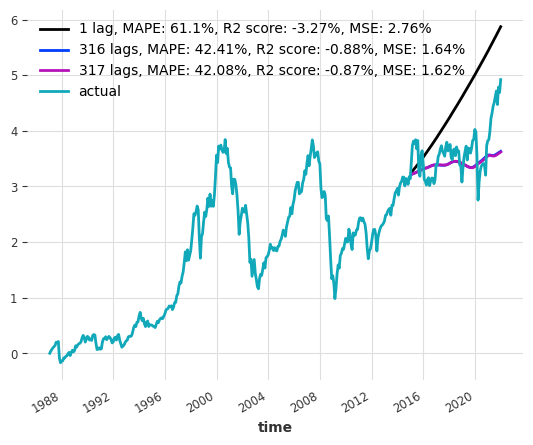

In [ ]:
# plot the pls forecast with 1, 316, 317  and label with MAPE rounded to 2 decimals and R2 score rounded to 2 decimals and MSE rounded to 2 decimals
pls_forecast_1['STOXX Europe 600'].plot(label='1 lag, MAPE: ' + str(round(mape(test, pls_forecast_1), 2)) + '%, R2 score: ' + str(round(r2_score(test, pls_forecast_1), 2)) + '%, MSE: ' + str(round(mse(test, pls_forecast_1), 2)) + '%')
pls_forecast_316['STOXX Europe 600'].plot(label='316 lags, MAPE: ' + str(round(mape(test, pls_forecast_316), 2)) + '%, R2 score: ' + str(round(r2_score(test, pls_forecast_316), 2)) + '%, MSE: ' + str(round(mse(test, pls_forecast_316), 2)) + '%')
pls_forecast_317['STOXX Europe 600'].plot(label='317 lags, MAPE: ' + str(round(mape(test, pls_forecast_317), 2)) + '%, R2 score: ' + str(round(r2_score(test, pls_forecast_317), 2)) + '%, MSE: ' + str(round(mse(test, pls_forecast_317), 2)) + '%')

# rewrite to see only one line
cum_returns['STOXX Europe 600'].plot(label='actual')

In [ ]:
pls_regression_tune = RegressionModel(
    lags= hyperparameter_pls['lags'][0],
    model=sklearn.cross_decomposition.PLSRegression(n_components=0)
)

In [ ]:
tuning_pls = pls_regression_tune.gridsearch(
    parameters= hyperparameter_pls,
    series= train,
    val_series= test,
    start= 0.1,
    metric= mse,
    n_jobs= -1,
    verbose= True
)

  0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
# print the best model parameters
best_model, best_params = tuning_pls[0], tuning_pls[1]
best_model.model_params

OrderedDict([('lags', 317),
             ('lags_past_covariates', None),
             ('lags_future_covariates', None),
             ('output_chunk_length', 1),
             ('add_encoders', None),
             ('model', PLSRegression(n_components=1)),
             ('multi_models', True),
             ('use_static_covariates', True)])

### Tuning PLS Canonical

In [ ]:
hyperparameter_canonical = {
    "lags": list(range(316,317,1)),
    'model': [
        sklearn.cross_decomposition.PLSCanonical(n_components=beta) for beta in np.arange(1, 15,1)
    ]
}

In [76]:
# canonical pls regression model with 1 lag
canonical_pls_model_1 = RegressionModel(lags=1, model=sklearn.cross_decomposition.PLSCanonical(n_components=10))
canonical_pls_model_1.fit(train)
canonical_pls_forecast_1 = canonical_pls_model_1.predict(len(test))

# canonical pls regression model with 316 lags
canonical_pls_model_316 = RegressionModel(lags=316, model=sklearn.cross_decomposition.PLSCanonical(n_components=5))
canonical_pls_model_316.fit(train)
canonical_pls_forecast_316 = canonical_pls_model_316.predict(len(test))

# canonical pls regression model with 317 lags
canonical_pls_model_317 = RegressionModel(lags=317, model=sklearn.cross_decomposition.PLSCanonical(n_components=14))
canonical_pls_model_317.fit(train)
canonical_pls_forecast_317 = canonical_pls_model_317.predict(len(test))

# canonical pls regression model with 335 lags
#canonical_pls_forecast_335 = RegressionModel(lags=335, model=sklearn.cross_decomposition.PLSCanonical(n_components=1))

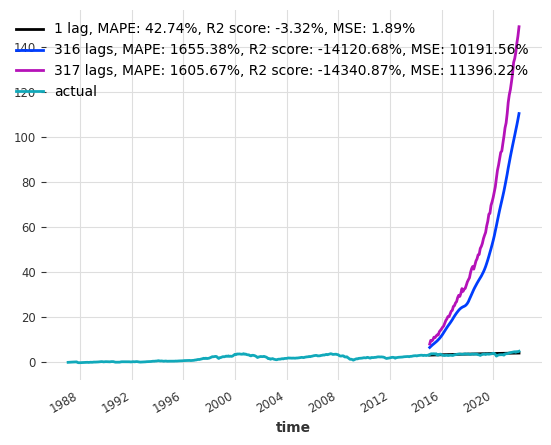

In [ ]:
# plot the canonical pls forecast with 1, 316, 317 and 335 and label with MAPE rounded to 2 decimals and R2 score rounded to 2 decimals and MSE rounded to 2 decimals
canonical_pls_forecast_1['STOXX Europe 600'].plot(label='1 lag, MAPE: ' + str(round(mape(test, canonical_pls_forecast_1), 2)) + '%, R2 score: ' + str(round(r2_score(test, canonical_pls_forecast_1), 2)) + '%, MSE: ' + str(round(mse(test, canonical_pls_forecast_1), 2)) + '%')
canonical_pls_forecast_316['STOXX Europe 600'].plot(label='316 lags, MAPE: ' + str(round(mape(test, canonical_pls_forecast_316), 2)) + '%, R2 score: ' + str(round(r2_score(test, canonical_pls_forecast_316), 2)) + '%, MSE: ' + str(round(mse(test, canonical_pls_forecast_316), 2)) + '%')
canonical_pls_forecast_317['STOXX Europe 600'].plot(label='317 lags, MAPE: ' + str(round(mape(test, canonical_pls_forecast_317), 2)) + '%, R2 score: ' + str(round(r2_score(test, canonical_pls_forecast_317), 2)) + '%, MSE: ' + str(round(mse(test, canonical_pls_forecast_317), 2)) + '%')
#canonical_pls_forecast_335['STOXX Europe 600'].plot(label='335 lags, MAPE: ' + str(round(mape(test, canonical_pls_forecast_335), 2)) + '%, R2 score: ' + str(round(r2_score(test, canonical_pls_forecast_335), 2)) + '%, MSE: ' + str(round(mse(test, canonical_pls_forecast_335), 2)) + '%')

# rewrite to see only one line
cum_returns['STOXX Europe 600'].plot(label='actual')

In [ ]:
# pls canonical regression model
pls_canonical_tune = RegressionModel(
    lags=hyperparameter_canonical['lags'][0], 
    model= sklearn.cross_decomposition.PLSCanonical(n_components=0)
    )

In [ ]:
tuning_canonical = pls_canonical_tune.gridsearch(
    parameters= hyperparameter_canonical,
    series= train,
    val_series= test,
    start= 0.1,
    metric= mse,
    n_jobs= -1,
    verbose= True
)

  0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
best_model, best_params = tuning_canonical[0], tuning_canonical[1]
best_model.model_params

OrderedDict([('lags', 316),
             ('lags_past_covariates', None),
             ('lags_future_covariates', None),
             ('output_chunk_length', 1),
             ('add_encoders', None),
             ('model', PLSCanonical(n_components=1)),
             ('multi_models', True),
             ('use_static_covariates', True)])

### Tuning CCA

In [ ]:
hyperparameter_cca = {
    "lags": list(range(1,2, 1)),
    'model': [
        sklearn.cross_decomposition.CCA(n_components=beta) for beta in np.arange(1, 15,1)
    ]
}

In [82]:
# cca regression model with 1 lag
cca_model_1 = RegressionModel(lags=1, model=sklearn.cross_decomposition.CCA(n_components=3))
cca_model_1.fit(train)
cca_forecast_1 = cca_model_1.predict(len(test))

# cca regression model with 316 lags
cca_model_316 = RegressionModel(lags=316, model=sklearn.cross_decomposition.CCA(n_components=1))
cca_model_316.fit(train)
cca_forecast_316 = cca_model_316.predict(len(test))

# cca regression model with 317 lags
cca_model_317 = RegressionModel(lags=317, model=sklearn.cross_decomposition.CCA(n_components=1))
cca_model_317.fit(train)
cca_forecast_317 = cca_model_317.predict(len(test))

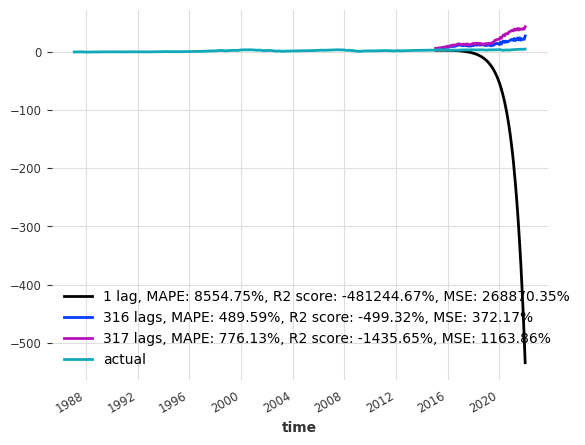

In [ ]:
# plot the cca forecast with 1, 316 and 317 and label with MAPE rounded to 2 decimals and R2 score rounded to 2 decimals and MSE rounded to 2 decimals
cca_forecast_1['STOXX Europe 600'].plot(label='1 lag, MAPE: ' + str(round(mape(test, cca_forecast_1), 2)) + '%, R2 score: ' + str(round(r2_score(test, cca_forecast_1), 2)) + '%, MSE: ' + str(round(mse(test, cca_forecast_1), 2)) + '%')
cca_forecast_316['STOXX Europe 600'].plot(label='316 lags, MAPE: ' + str(round(mape(test, cca_forecast_316), 2)) + '%, R2 score: ' + str(round(r2_score(test, cca_forecast_316), 2)) + '%, MSE: ' + str(round(mse(test, cca_forecast_316), 2)) + '%')
cca_forecast_317['STOXX Europe 600'].plot(label='317 lags, MAPE: ' + str(round(mape(test, cca_forecast_317), 2)) + '%, R2 score: ' + str(round(r2_score(test, cca_forecast_317), 2)) + '%, MSE: ' + str(round(mse(test, cca_forecast_317), 2)) + '%')

# rewrite to see only one line
cum_returns['STOXX Europe 600'].plot(label='actual')

In [ ]:
cca_tune = RegressionModel(
    lags= hyperparameter_cca['lags'][0],
    model=sklearn.cross_decomposition.CCA(n_components=0)
)

In [ ]:
tuning_cca = cca_tune.gridsearch(
    parameters= hyperparameter_cca,
    series= train,
    val_series= test,
    start= 0.1,
    metric= mape,
    n_jobs= -1,
    verbose= True
)

  0%|          | 0/14 [00:00<?, ?it/s]

/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/Users/antonkruse/.pyenv/ver

In [ ]:
# print the best model parameters
best_model, best_params = tuning_cca[0], tuning_cca[1]
best_model.model_params

OrderedDict([('lags', 1),
             ('lags_past_covariates', None),
             ('lags_future_covariates', None),
             ('output_chunk_length', 1),
             ('add_encoders', None),
             ('model', CCA()),
             ('multi_models', True),
             ('use_static_covariates', True)])

## Hyperparameter Nonlinear ML

### Tuning Random Forest

In [64]:
hyperparameter_randomforest = {
    "lags": [1, 316, 317, 335],
    #'n_estimators': list(range(1, 101)),
    'max_depth': list(range(1, 501)),
}

Influence of the parameter 'n_components' & best performing lags:

- 1 lag  MAPE: "469" - 38.25

In [68]:
# random forest regression model with 1 lag
randomforest_model_1 = RegressionModel(lags=1, model=sklearn.ensemble.RandomForestRegressor(n_estimators=100, max_depth=300))
randomforest_model_1.fit(train)
randomforest_forecast_1 = randomforest_model_1.predict(len(test))

# random forest regression model with 316 lags
randomforest_model_316 = RegressionModel(lags=316, model=sklearn.ensemble.RandomForestRegressor(n_estimators=100, max_depth=10000))
randomforest_model_316.fit(train)
randomforest_forecast_316 = randomforest_model_316.predict(len(test))

# random forest regression model with 317 lags
randomforest_model_317 = RegressionModel(lags=317, model=sklearn.ensemble.RandomForestRegressor(n_estimators=100, max_depth=10))
randomforest_model_317.fit(train)
randomforest_forecast_317 = randomforest_model_317.predict(len(test))

# random forest regression model with 335 lags
randomforest_model_335 = RegressionModel(lags=335, model=sklearn.ensemble.RandomForestRegressor(n_estimators=100, max_depth=1))
randomforest_model_335.fit(train)
randomforest_forecast_335 = randomforest_model_335.predict(len(test))

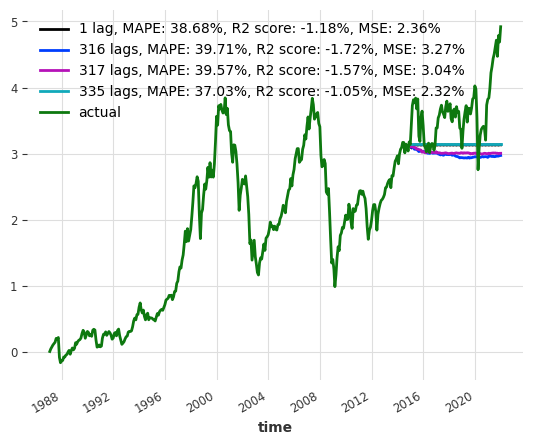

In [69]:
# plot the random forest forecast with 1, 316, 317 and 335 lags and label with MAPE rounded to 2 decimals and R2 score rounded to 2 decimals and MSE rounded to 2 decimals
randomforest_forecast_1['STOXX Europe 600'].plot(label='1 lag, MAPE: ' + str(round(mape(test, randomforest_forecast_1), 2)) + '%, R2 score: ' + str(round(r2_score(test, randomforest_forecast_1), 2)) + '%, MSE: ' + str(round(mse(test, randomforest_forecast_1), 2)) + '%')
randomforest_forecast_316['STOXX Europe 600'].plot(label='316 lags, MAPE: ' + str(round(mape(test, randomforest_forecast_316), 2)) + '%, R2 score: ' + str(round(r2_score(test, randomforest_forecast_316), 2)) + '%, MSE: ' + str(round(mse(test, randomforest_forecast_316), 2)) + '%')
randomforest_forecast_317['STOXX Europe 600'].plot(label='317 lags, MAPE: ' + str(round(mape(test, randomforest_forecast_317), 2)) + '%, R2 score: ' + str(round(r2_score(test, randomforest_forecast_317), 2)) + '%, MSE: ' + str(round(mse(test, randomforest_forecast_317), 2)) + '%')
randomforest_forecast_335['STOXX Europe 600'].plot(label='335 lags, MAPE: ' + str(round(mape(test, randomforest_forecast_335), 2)) + '%, R2 score: ' + str(round(r2_score(test, randomforest_forecast_335), 2)) + '%, MSE: ' + str(round(mse(test, randomforest_forecast_335), 2)) + '%')

# rewrite to see only one line
cum_returns['STOXX Europe 600'].plot(label='actual')

In [65]:
random_forest_tune = RandomForest(
    lags=hyperparameter_randomforest['lags'][0], 
   # n_estimators=hyperparameter_randomforest['n_estimators'][0],
    max_depth=hyperparameter_randomforest['max_depth'][0]
    )

In [66]:
tuning_randomforest = random_forest_tune.gridsearch(
    parameters= hyperparameter_randomforest,
    series= train,
    val_series= test,
    start= 0.1,
    metric= mse,
    n_jobs= -1,
    verbose= True
)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [67]:
# print the best model parameters
best_model, best_params = tuning_randomforest[0], tuning_randomforest[1]
best_model.model_params

OrderedDict([('lags', 335),
             ('lags_past_covariates', None),
             ('lags_future_covariates', None),
             ('output_chunk_length', 1),
             ('add_encoders', None),
             ('n_estimators', 100),
             ('max_depth', 1),
             ('multi_models', True),
             ('use_static_covariates', True)])

### Tuning Gradient Boosting Regressor

In [38]:
hyperparameter_gradient_boosting = {
    "lags": [316], #1, 316, 317, 335
    'model': [
        GradientBoostingRegressor(learning_rate=l, max_depth=m, random_state=0)  #n_estimators=n, 
       # for n in range(1, 100, 1) 
        for m in range(1, 500, 1)
        for l in np.arange(0.1, 1, 0.2)
    ]
}

In [49]:
# gradient boosting regression model with 1 lag
gradient_boosting_model_1 = RegressionModel(lags=1, model=sklearn.ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=1, learning_rate=0.9))
gradient_boosting_model_1.fit(train)
gradient_boosting_forecast_1 = gradient_boosting_model_1.predict(len(test))

# gradient boosting regression model with 316 lags
gradient_boosting_model_316 = RegressionModel(lags=316, model=sklearn.ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=400, learning_rate=0.5))
gradient_boosting_model_316.fit(train)
gradient_boosting_forecast_316 = gradient_boosting_model_316.predict(len(test))

# gradient boosting regression model with 317 lags
gradient_boosting_model_317 = RegressionModel(lags=317, model=sklearn.ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=400, learning_rate=0.5))
gradient_boosting_model_317.fit(train)
gradient_boosting_forecast_317 = gradient_boosting_model_317.predict(len(test))

# gradient boosting regression model with 335 lags
gradient_boosting_model_335 = RegressionModel(lags=335, model=sklearn.ensemble.GradientBoostingRegressor(n_estimators=1000, max_depth=800, learning_rate=0.9))
gradient_boosting_model_335.fit(train)
gradient_boosting_forecast_335 = gradient_boosting_model_335.predict(len(test))

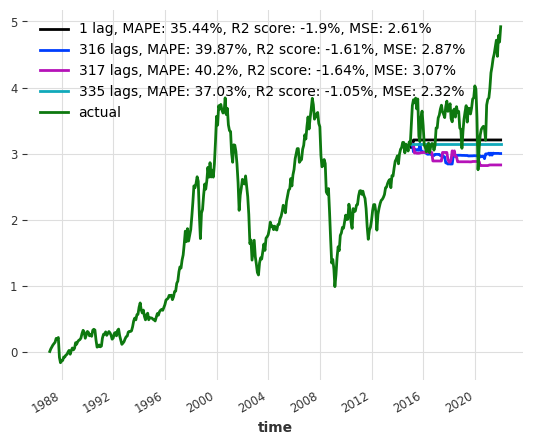

In [50]:
# plot the gradient boosting forecast with 1, 316, 317 and 335 lags and label with MAPE rounded to 2 decimals and R2 score rounded to 2 decimals and MSE rounded to 2 decimals
gradient_boosting_forecast_1['STOXX Europe 600'].plot(label='1 lag, MAPE: ' + str(round(mape(test, gradient_boosting_forecast_1), 2)) + '%, R2 score: ' + str(round(r2_score(test, gradient_boosting_forecast_1), 2)) + '%, MSE: ' + str(round(mse(test, gradient_boosting_forecast_1), 2)) + '%')
gradient_boosting_forecast_316['STOXX Europe 600'].plot(label='316 lags, MAPE: ' + str(round(mape(test, gradient_boosting_forecast_316), 2)) + '%, R2 score: ' + str(round(r2_score(test, gradient_boosting_forecast_316), 2)) + '%, MSE: ' + str(round(mse(test, gradient_boosting_forecast_316), 2)) + '%')
gradient_boosting_forecast_317['STOXX Europe 600'].plot(label='317 lags, MAPE: ' + str(round(mape(test, gradient_boosting_forecast_317), 2)) + '%, R2 score: ' + str(round(r2_score(test, gradient_boosting_forecast_317), 2)) + '%, MSE: ' + str(round(mse(test, gradient_boosting_forecast_317), 2)) + '%')
gradient_boosting_forecast_335['STOXX Europe 600'].plot(label='335 lags, MAPE: ' + str(round(mape(test, gradient_boosting_forecast_335), 2)) + '%, R2 score: ' + str(round(r2_score(test, gradient_boosting_forecast_335), 2)) + '%, MSE: ' + str(round(mse(test, gradient_boosting_forecast_335), 2)) + '%')

# rewrite to see only one line
cum_returns['STOXX Europe 600'].plot(label='actual')

In [17]:
gradient_boosting_tune = RegressionModel(
    lags= hyperparameter_gradient_boosting['lags'][0],
    model=GradientBoostingRegressor(n_estimators=0, learning_rate=0, max_depth=0, random_state=0)
)

In [51]:
tuning_gradient_boosting = gradient_boosting_tune.gridsearch(
    parameters= hyperparameter_gradient_boosting,
    series= train,
    val_series= test,
    start= 0.1,
    metric= mape,
    n_jobs= -1,
    verbose= True
)

  0%|          | 0/2495 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [37]:
# print the best model parameters
best_model, best_params = tuning_gradient_boosting[0], tuning_gradient_boosting[1]
best_model.model_params

OrderedDict([('lags', 1),
             ('lags_past_covariates', None),
             ('lags_future_covariates', None),
             ('output_chunk_length', 1),
             ('add_encoders', None),
             ('model',
              GradientBoostingRegressor(learning_rate=0.9000000000000001, max_depth=1,
                                        random_state=0)),
             ('multi_models', True),
             ('use_static_covariates', True)])

### Tuning Ada Boosting Regressor

In [ ]:
hyperparameter_ada_boosting = {
    "lags": list(range(1,201)),
    'model': [
        sklearn.ensemble.AdaBoostRegressor(n_estimators=n, learning_rate=l, random_state=0) 
        for n in np.arange(1, 101, 1)
        for l in np.arange(0.1, 1, 0.01)
    ]
}

In [ ]:
ada_boosting_tune = RegressionModel(
    lags= hyperparameter_ada_boosting['lags'][0],
    model=sklearn.ensemble.AdaBoostRegressor(n_estimators=0, random_state=0)
)

In [ ]:
tuning_ada_boosting = ada_boosting_tune.gridsearch(
    parameters= hyperparameter_ada_boosting,
    series= train,
    val_series= test,
    start= 0.1,
    metric= mape,
    n_jobs= -1,
    verbose= True
)

  0%|          | 0/900 [00:00<?, ?it/s]

In [ ]:
# print the best model parameters
best_model, best_params = tuning_ada_boosting[0], tuning_ada_boosting[1]
best_model.model_params

OrderedDict([('lags', 4),
             ('lags_past_covariates', None),
             ('lags_future_covariates', None),
             ('output_chunk_length', 1),
             ('add_encoders', None),
             ('model', AdaBoostRegressor(n_estimators=4, random_state=0)),
             ('multi_models', True),
             ('use_static_covariates', True)])

### Tuning Extra Trees Regressor

In [ ]:
hyperparameter_extra_tress = {
    "lags": list(range(1, 201)),
    'model': [
        sklearn.ensemble.ExtraTreesRegressor(n_estimators=n, max_depth=m, min_samples_split=s, random_state=0) 
        for n in np.arange(1, 201, 1)
        for m in np.arange(1, 51, 1)
        for s in np.arange(2, 21, 1)
    ]
}

In [ ]:
extra_trees_tune = RegressionModel(
    lags= hyperparameter_extra_tress['lags'][0],
    model=sklearn.ensemble.ExtraTreesRegressor(n_estimators=0, max_depth=0, min_samples_split=0, random_state=0)
)

In [ ]:
tuning_extra_trees = extra_trees_tune.gridsearch(
    parameters= hyperparameter_extra_tress,
    series= train,
    val_series= test,
    start= 0.1,
    metric= mape,
    n_jobs= -1,
    verbose= True
)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
# print the best model parameters
best_model, best_params = tuning_extra_trees[0], tuning_extra_trees[1]
best_model.model_params

OrderedDict([('lags', 45),
             ('lags_past_covariates', None),
             ('lags_future_covariates', None),
             ('output_chunk_length', 1),
             ('add_encoders', None),
             ('model',
              ExtraTreesRegressor(max_depth=5, min_samples_split=3, n_estimators=4,
                                  random_state=0)),
             ('multi_models', True),
             ('use_static_covariates', True)])

### Tuning Support Vector Regression

In [ ]:
hyperparameter_support_vector = {
    "lags": list(range(1,201)),
    'model': [
        sklearn.svm.SVR(kernel= k, C= c, gamma= g) 
        for g in ['scale', 'auto'] 
        for k in ['linear', 'poly', 'rbf', 'sigmoid']
        for c in np.arange(0.1, 1, 0.01)
    ]
}

In [ ]:
support_vector_tune = RegressionModel(
    lags= hyperparameter_support_vector['lags'][0],
    model=sklearn.svm.SVR(kernel= 'linear', C= 0.1, gamma= 'scale')
)

In [ ]:
"""tuning_support_vector = support_vector_tune.gridsearch(
    parameters= hyperparameter_support_vector,
    series= train,
    val_series= test,
    start= 0.1,
    metric= mape,
    n_jobs= -1,
    verbose= True
)
"""

  0%|          | 0/7200 [00:00<?, ?it/s]

ValueError: Input X contains NaN.
SVR does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# print the best model parameters
best_model, best_params = tuning_support_vector[0], tuning_support_vector[1]
best_model.model_params

# Backtesting

"So at this point we have a model that performs well on our validation set, and that’s good. But, how can we know the performance we would have obtained if we had been using this model historically?

Backtesting simulates predictions that would have been obtained historically with a given model. It can take a while to produce, since the model is (by default) re-trained every time the simulated prediction time advances."

Use example of benchmark STOXX Europe 600.

## Shrinkage

### Linear Regression HF

In [59]:
# first linear regression model with 1 lag
hf1_linear_regression = linear_model_1.historical_forecasts(
    series= cum_returns,    # the target time series used to successively train and compute the historical forecasts.
    start= 0.7,             # first point in time at which a prediction is computed for a future time
    forecast_horizon= 1,    # the forecast horizon for the predictions
    verbose= True
)

# second linear regression model with 316 lags
hf2_linear_regression = linear_model_316.historical_forecasts(
    series= cum_returns,    # the target time series used to successively train and compute the historical forecasts.
    start= 0.7,             # first point in time at which a prediction is computed for a future time
    forecast_horizon= 1,    # the forecast horizon for the predictions
    verbose= True
)

# third linear regression model with 317 lags
hf3_linear_regression = linear_model_317.historical_forecasts(
    series= cum_returns,    # the target time series used to successively train and compute the historical forecasts.
    start= 0.7,             # first point in time at which a prediction is computed for a future time
    forecast_horizon= 1,    # the forecast horizon for the predictions
    verbose= True
)

# fourth linear regression model with 335 lags
hf4_linear_regression = linear_model_335.historical_forecasts(
    series= cum_returns,    # the target time series used to successively train and compute the historical forecasts.
    start= 0.7,             # first point in time at which a prediction is computed for a future time
    forecast_horizon= 1,    # the forecast horizon for the predictions
    verbose= True
)

  0%|          | 0/127 [00:00<?, ?it/s]

`start` value `0.7` corresponding to timestamp `2011-07-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2013-08-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/102 [00:00<?, ?it/s]

`start` value `0.7` corresponding to timestamp `2011-07-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2013-09-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/101 [00:00<?, ?it/s]

`start` value `0.7` corresponding to timestamp `2011-07-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2015-03-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/83 [00:00<?, ?it/s]

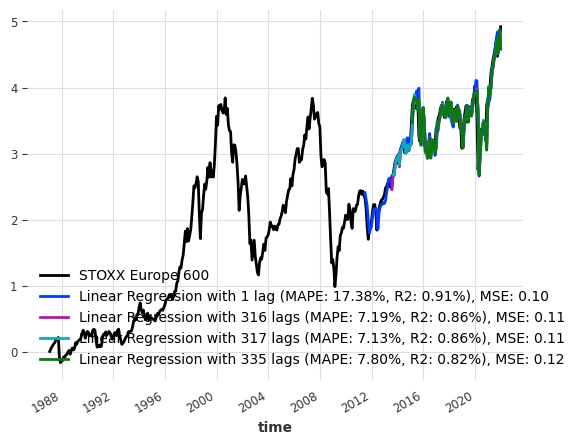

In [60]:
# plot the historical forecasts and label it with MAPE
err1 = mape(hf1_linear_regression, cum_returns)
err2 = mape(hf2_linear_regression, cum_returns)
err3 = mape(hf3_linear_regression, cum_returns)
err4 = mape(hf4_linear_regression, cum_returns)
r2_1 = r2_score(hf1_linear_regression, cum_returns)
r2_2 = r2_score(hf2_linear_regression, cum_returns)
r2_3 = r2_score(hf3_linear_regression, cum_returns)
r2_4 = r2_score(hf4_linear_regression, cum_returns)
mse_1 = mse(hf1_linear_regression, cum_returns)
mse_2 = mse(hf2_linear_regression, cum_returns)
mse_3 = mse(hf3_linear_regression, cum_returns)
mse_4 = mse(hf4_linear_regression, cum_returns)

# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_linear_regression['STOXX Europe 600'].plot(label='Linear Regression with 1 lag (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf1_linear_regression, cum_returns), r2_score(hf1_linear_regression, cum_returns), mse(hf1_linear_regression, cum_returns)))
hf2_linear_regression['STOXX Europe 600'].plot(label='Linear Regression with 316 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(err2, r2_2, mse_2))
hf3_linear_regression['STOXX Europe 600'].plot(label='Linear Regression with 317 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(err3, r2_3, mse_3))
hf4_linear_regression['STOXX Europe 600'].plot(label='Linear Regression with 335 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(err4, r2_4, mse_4))

# save this plot to wandb
wandb.log({'Historical Forecast Linear Regression': wandb.Image(plt)})

### Ridge Regression HF

In [70]:
# first ridge regression model with 1 lag
hf1_ridge_regression = ridge_model_1.historical_forecasts(
    series= cum_returns,    # the target time series used to successively train and compute the historical forecasts.
    start= 0.7,             # first point in time at which a prediction is computed for a future time
    forecast_horizon= 1,    # the forecast horizon for the predictions
    verbose= True
)

# second ridge regression model with 316 lags
hf2_ridge_regression = ridge_model_316.historical_forecasts(
    series= cum_returns,    # the target time series used to successively train and compute the historical forecasts.
    start= 0.7,             # first point in time at which a prediction is computed for a future time
    forecast_horizon= 1,    # the forecast horizon for the predictions
    verbose= True
)

# third ridge regression model with 317 lags
hf3_ridge_regression = ridge_model_317.historical_forecasts(
    series= cum_returns,    # the target time series used to successively train and compute the historical forecasts.
    start= 0.7,             # first point in time at which a prediction is computed for a future time
    forecast_horizon= 1,    # the forecast horizon for the predictions
    verbose= True
)

# fourth ridge regression model with 335 lags
hf4_ridge_regression = ridge_model_335.historical_forecasts(
    series= cum_returns,    # the target time series used to successively train and compute the historical forecasts.
    start= 0.7,             # first point in time at which a prediction is computed for a future time
    forecast_horizon= 1,    # the forecast horizon for the predictions
    verbose= True
)

  0%|          | 0/127 [00:00<?, ?it/s]

`start` value `0.7` corresponding to timestamp `2011-07-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2013-08-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/102 [00:00<?, ?it/s]

/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=3.40111e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=4.73042e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=7.16381e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=7.06493e-18): result may not be accurate.
  dual_coef = linalg.solve(K

  0%|          | 0/101 [00:00<?, ?it/s]

/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.25173e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=7.08601e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=3.89981e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=5.08373e-18): result may not be accurate.
  dual_coef = linalg.solve(K

  0%|          | 0/83 [00:00<?, ?it/s]

/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=3.27987e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=3.3385e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=4.88281e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=5.31297e-18): result may not be accurate.
  dual_coef = linalg.solve(K,

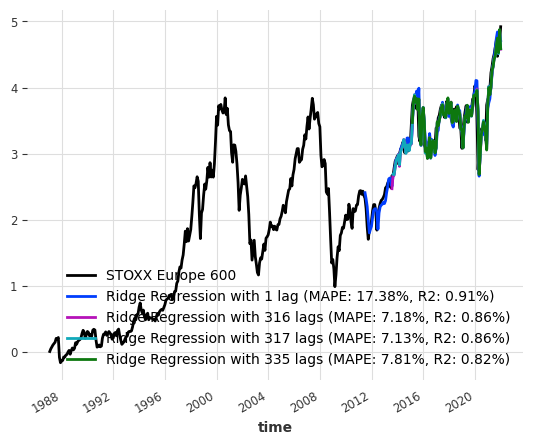

In [71]:
# plot the historical forecasts and label it with MAPE and R2
err1 = mape(hf1_ridge_regression, cum_returns)
err2 = mape(hf2_ridge_regression, cum_returns)
err3 = mape(hf3_ridge_regression, cum_returns)
err4 = mape(hf4_ridge_regression, cum_returns)
r2_1 = r2_score(hf1_ridge_regression, cum_returns)
r2_2 = r2_score(hf2_ridge_regression, cum_returns)
r2_3 = r2_score(hf3_ridge_regression, cum_returns)
r2_4 = r2_score(hf4_ridge_regression, cum_returns)

# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_ridge_regression['STOXX Europe 600'].plot(label='Ridge Regression with 1 lag (MAPE: {:.2f}%, R2: {:.2f}%)'.format(err1, r2_1))
hf2_ridge_regression['STOXX Europe 600'].plot(label='Ridge Regression with 316 lags (MAPE: {:.2f}%, R2: {:.2f}%)'.format(err2, r2_2))
hf3_ridge_regression['STOXX Europe 600'].plot(label='Ridge Regression with 317 lags (MAPE: {:.2f}%, R2: {:.2f}%)'.format(err3, r2_3))
hf4_ridge_regression['STOXX Europe 600'].plot(label='Ridge Regression with 335 lags (MAPE: {:.2f}%, R2: {:.2f}%)'.format(err4, r2_4))

# save this plot to wandb
wandb.log({'Historical Forecast Ridge Regression': wandb.Image(plt)})

### Lasso Regression HF

In [94]:
# first lasso regression model with 1 lag
hf1_lasso_regression = lasso_model_1.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

# second lasso regression model with 316 lags
hf2_lasso_regression = lasso_model_316.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

# third lasso regression model with 317 lags
hf3_lasso_regression = lasso_model_317.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

# fourth lasso regression model with 335 lags
hf4_lasso_regression = lasso_model_335.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

  0%|          | 0/127 [00:00<?, ?it/s]

`start` value `0.7` corresponding to timestamp `2011-07-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2013-08-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/102 [00:00<?, ?it/s]

`start` value `0.7` corresponding to timestamp `2011-07-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2013-09-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/101 [00:00<?, ?it/s]

`start` value `0.7` corresponding to timestamp `2011-07-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2015-03-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/83 [00:00<?, ?it/s]

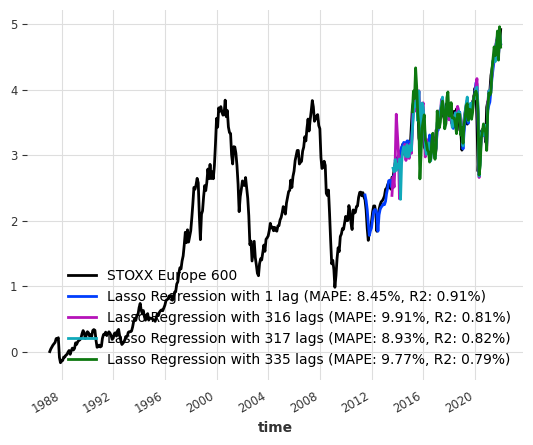

In [97]:
# plot the historical forecasts and label it with MAPE and R2
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_lasso_regression['STOXX Europe 600'].plot(label='Lasso Regression with 1 lag (MAPE: {:.2f}%, R2: {:.2f}%)'.format(mape(hf1_lasso_regression, cum_returns), r2_score(hf1_lasso_regression, cum_returns)))
hf2_lasso_regression['STOXX Europe 600'].plot(label='Lasso Regression with 316 lags (MAPE: {:.2f}%, R2: {:.2f}%)'.format(mape(hf2_lasso_regression, cum_returns), r2_score(hf2_lasso_regression, cum_returns)))
hf3_lasso_regression['STOXX Europe 600'].plot(label='Lasso Regression with 317 lags (MAPE: {:.2f}%, R2: {:.2f}%)'.format(mape(hf3_lasso_regression, cum_returns), r2_score(hf3_lasso_regression, cum_returns)))
hf4_lasso_regression['STOXX Europe 600'].plot(label='Lasso Regression with 335 lags (MAPE: {:.2f}%, R2: {:.2f}%)'.format(mape(hf4_lasso_regression, cum_returns), r2_score(hf4_lasso_regression, cum_returns)))

# save this plot to wandb
wandb.log({'Historical Forecast Lasso Regression': wandb.Image(plt)})

### Elastic Net HF

In [101]:
# first elastic net regression model with 1 lag
hf1_elastic_net_regression = elastic_model_1.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

# second elastic net regression model with 316 lags
hf2_elastic_net_regression = elastic_model_316.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

# third elastic net regression model with 317 lags
hf3_elastic_net_regression = elastic_model_317.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

# fourth elastic net regression model with 335 lags
hf4_elastic_net_regression = elastic_model_335.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

  0%|          | 0/127 [00:00<?, ?it/s]

`start` value `0.7` corresponding to timestamp `2011-07-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2013-08-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/102 [00:00<?, ?it/s]

`start` value `0.7` corresponding to timestamp `2011-07-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2013-09-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/101 [00:00<?, ?it/s]

`start` value `0.7` corresponding to timestamp `2011-07-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2015-03-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/83 [00:00<?, ?it/s]

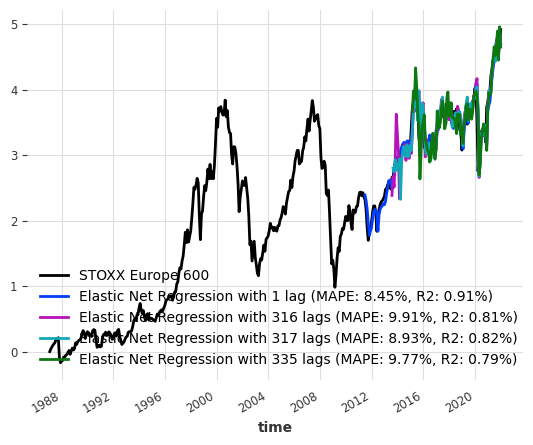

In [102]:
# plot the historical forecasts and label it with MAPE and R2
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_elastic_net_regression['STOXX Europe 600'].plot(label='Elastic Net Regression with 1 lag (MAPE: {:.2f}%, R2: {:.2f}%)'.format(mape(hf1_elastic_net_regression, cum_returns), r2_score(hf1_elastic_net_regression, cum_returns)))
hf2_elastic_net_regression['STOXX Europe 600'].plot(label='Elastic Net Regression with 316 lags (MAPE: {:.2f}%, R2: {:.2f}%)'.format(mape(hf2_elastic_net_regression, cum_returns), r2_score(hf2_elastic_net_regression, cum_returns)))
hf3_elastic_net_regression['STOXX Europe 600'].plot(label='Elastic Net Regression with 317 lags (MAPE: {:.2f}%, R2: {:.2f}%)'.format(mape(hf3_elastic_net_regression, cum_returns), r2_score(hf3_elastic_net_regression, cum_returns)))
hf4_elastic_net_regression['STOXX Europe 600'].plot(label='Elastic Net Regression with 335 lags (MAPE: {:.2f}%, R2: {:.2f}%)'.format(mape(hf4_elastic_net_regression, cum_returns), r2_score(hf4_elastic_net_regression, cum_returns)))

# save this plot to wandb
wandb.log({'Historical Forecast Elastic Net Regression': wandb.Image(plt)})

### Bridge Regression HF

  0%|          | 0/127 [00:00<?, ?it/s]

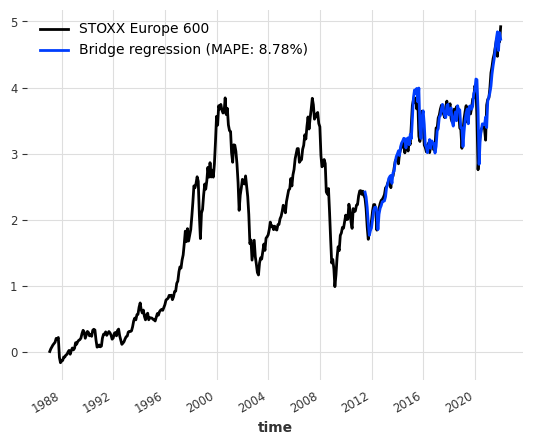

In [ ]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')

hf_bridge_regression = bridge_regression.historical_forecasts(
    series= cum_returns,    # the target time series used to successively train and compute the historical forecasts.
    start= 0.7,             # first point in time at which a prediction is computed for a future time
    forecast_horizon= 1,    # the forecast horizon for the predictions
    verbose= True
)
# plot the historical forecasts and label it with MAPE
err = mape(hf_bridge_regression, cum_returns)
hf_bridge_regression['STOXX Europe 600'].plot(label= 'Bridge regression (MAPE: {:.2f}%)'.format(err))

# save this plot to wandb
wandb.log({'Historical Forecast Bridge Regression': wandb.Image(plt)})

## Dimensionality Reduction

### PLS Regression HF

In [73]:
# first pls regression model with 1 lag
hf1_pls_regression = pls_model_1.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

# second pls regression model with 316 lags
hf2_pls_regression = pls_model_316.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

# third pls regression model with 317 lags
hf3_pls_regression = pls_model_317.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

  0%|          | 0/127 [00:00<?, ?it/s]

`start` value `0.7` corresponding to timestamp `2011-07-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2013-08-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/102 [00:00<?, ?it/s]

`start` value `0.7` corresponding to timestamp `2011-07-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2013-09-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/101 [00:00<?, ?it/s]

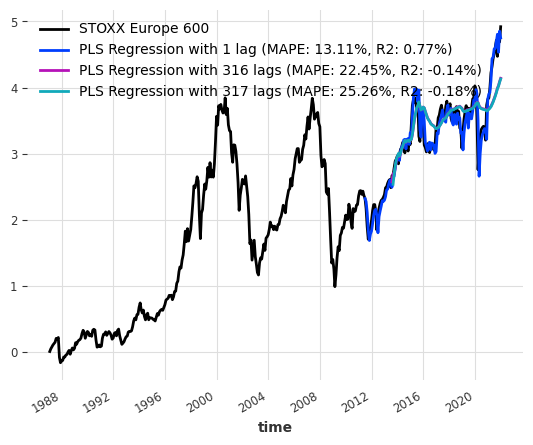

In [74]:
# plot the historical forecasts and label it with MAPE and R2
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_pls_regression['STOXX Europe 600'].plot(label='PLS Regression with 1 lag (MAPE: {:.2f}%, R2: {:.2f}%)'.format(mape(hf1_pls_regression, cum_returns), r2_score(hf1_pls_regression, cum_returns)))
hf2_pls_regression['STOXX Europe 600'].plot(label='PLS Regression with 316 lags (MAPE: {:.2f}%, R2: {:.2f}%)'.format(mape(hf2_pls_regression, cum_returns), r2_score(hf2_pls_regression, cum_returns)))
hf3_pls_regression['STOXX Europe 600'].plot(label='PLS Regression with 317 lags (MAPE: {:.2f}%, R2: {:.2f}%)'.format(mape(hf3_pls_regression, cum_returns), r2_score(hf3_pls_regression, cum_returns)))

# save this plot to wandb
wandb.log({'Historical Forecast PLS Regression': wandb.Image(plt)})

### PLS Canonical HF

In [78]:
# first canonical pls model with 1 lag
hf1_canonical_pls = canonical_pls_model_1.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

  0%|          | 0/127 [00:00<?, ?it/s]

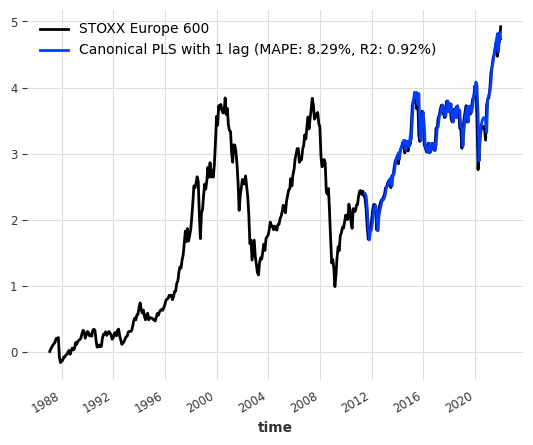

In [80]:
# plot the historical forecasts and label it with MAPE and R2
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_canonical_pls['STOXX Europe 600'].plot(label='Canonical PLS with 1 lag (MAPE: {:.2f}%, R2: {:.2f}%)'.format(mape(hf1_canonical_pls, cum_returns), r2_score(hf1_canonical_pls, cum_returns)))

# save this plot to wandb
wandb.log({'Historical Forecast Canonical PLS': wandb.Image(plt)})

### CCA HF

In [83]:
# first cca model with 1 lag
hf1_cca = cca_model_1.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

# second cca model with 316 lags
hf2_cca = cca_model_316.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

# third cca model with 317 lags
hf3_cca = cca_model_317.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

  0%|          | 0/127 [00:00<?, ?it/s]

`start` value `0.7` corresponding to timestamp `2011-07-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2013-08-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/102 [00:00<?, ?it/s]

`start` value `0.7` corresponding to timestamp `2011-07-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2013-09-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/101 [00:00<?, ?it/s]

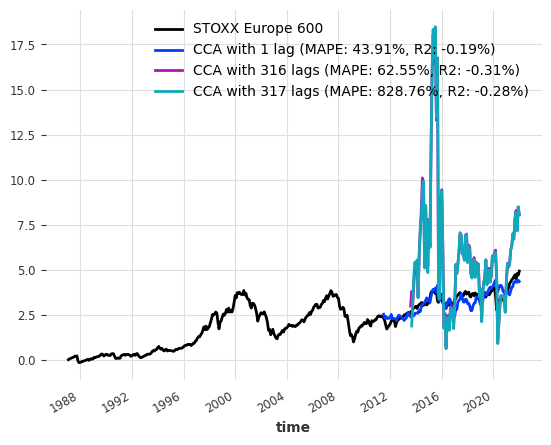

In [84]:
# plot the historical forecasts and label it with MAPE and R2
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_cca['STOXX Europe 600'].plot(label='CCA with 1 lag (MAPE: {:.2f}%, R2: {:.2f}%)'.format(mape(hf1_cca, cum_returns), r2_score(hf1_cca, cum_returns)))
hf2_cca['STOXX Europe 600'].plot(label='CCA with 316 lags (MAPE: {:.2f}%, R2: {:.2f}%)'.format(mape(hf2_cca, cum_returns), r2_score(hf2_cca, cum_returns)))
hf3_cca['STOXX Europe 600'].plot(label='CCA with 317 lags (MAPE: {:.2f}%, R2: {:.2f}%)'.format(mape(hf3_cca, cum_returns), r2_score(hf3_cca, cum_returns)))

# save this plot to wandb
wandb.log({'Historical Forecast CCA': wandb.Image(plt)})

  0%|          | 0/127 [00:00<?, ?it/s]

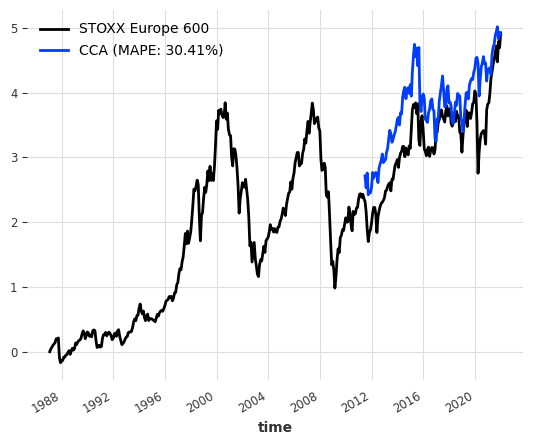

In [ ]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')

hf_cca = cca.historical_forecasts(
    series= cum_returns,    # the target time series used to successively train and compute the historical forecasts.
    start= 0.7,             # first point in time at which a prediction is computed for a future time
    forecast_horizon= 1,    # the forecast horizon for the predictions
    verbose= True
)
# plot the historical forecasts and label it with MAPE
err = mape(hf_cca, cum_returns)
hf_cca['STOXX Europe 600'].plot(label= 'CCA (MAPE: {:.2f}%)'.format(err))

# save this plot to wandb
wandb.log({'Historical Forecast CCA': wandb.Image(plt)})

## Nonlinear ML

### Random Forest HF

In [85]:
# first random forest model with 1 lag
hf1_random_forest = randomforest_model_1.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

# second random forest model with 316 lags
hf2_random_forest = randomforest_model_316.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

# third random forest model with 317 lags
hf3_random_forest = randomforest_model_317.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

# fourth random forest model with 335 lags
hf4_random_forest = randomforest_model_335.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

  0%|          | 0/127 [00:00<?, ?it/s]

`start` value `0.7` corresponding to timestamp `2011-07-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2013-08-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/102 [00:00<?, ?it/s]

`start` value `0.7` corresponding to timestamp `2011-07-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2013-09-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/101 [00:00<?, ?it/s]

wandb: Network error (ConnectionError), entering retry loop.
`start` value `0.7` corresponding to timestamp `2011-07-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2015-03-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/83 [00:00<?, ?it/s]

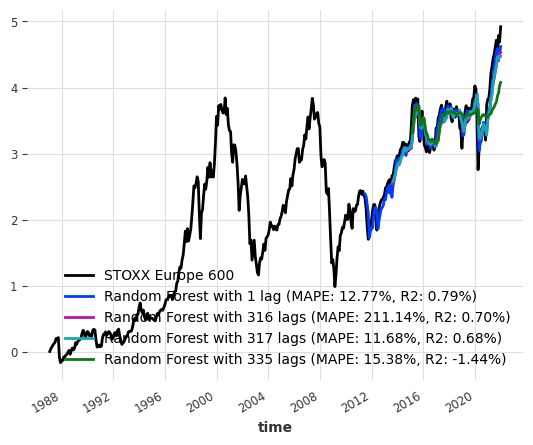

In [86]:
# plot the historical forecasts and label it with MAPE and R2
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_random_forest['STOXX Europe 600'].plot(label='Random Forest with 1 lag (MAPE: {:.2f}%, R2: {:.2f}%)'.format(mape(hf1_random_forest, cum_returns), r2_score(hf1_random_forest, cum_returns)))
hf2_random_forest['STOXX Europe 600'].plot(label='Random Forest with 316 lags (MAPE: {:.2f}%, R2: {:.2f}%)'.format(mape(hf2_random_forest, cum_returns), r2_score(hf2_random_forest, cum_returns)))
hf3_random_forest['STOXX Europe 600'].plot(label='Random Forest with 317 lags (MAPE: {:.2f}%, R2: {:.2f}%)'.format(mape(hf3_random_forest, cum_returns), r2_score(hf3_random_forest, cum_returns)))
hf4_random_forest['STOXX Europe 600'].plot(label='Random Forest with 335 lags (MAPE: {:.2f}%, R2: {:.2f}%)'.format(mape(hf4_random_forest, cum_returns), r2_score(hf4_random_forest, cum_returns)))

# save this plot to wandb
wandb.log({'Historical Forecast Random Forest': wandb.Image(plt)})

  0%|          | 0/127 [00:00<?, ?it/s]

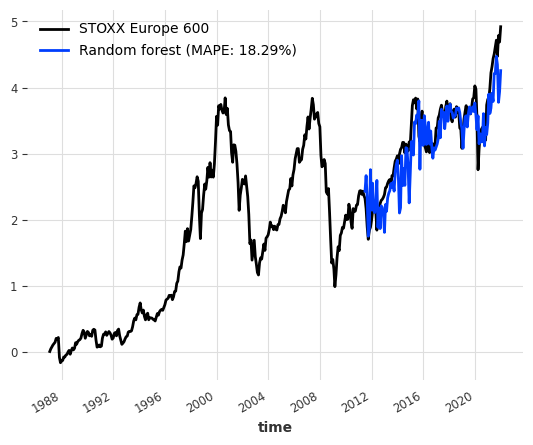

In [ ]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')

hf_random_forest = random_forest.historical_forecasts(
    series= cum_returns,
    start= 0.7,
    forecast_horizon= 1,
    verbose= True
)
# plot the historical forecasts and label it with MAPE
err = mape(hf_random_forest, cum_returns)
hf_random_forest['STOXX Europe 600'].plot(label= 'Random forest (MAPE: {:.2f}%)'.format(err))

# save this plot to wandb
wandb.log({'Historical Forecast Random Forest': wandb.Image(plt)})

### Gradient Boosting HF

  0%|          | 0/127 [00:00<?, ?it/s]

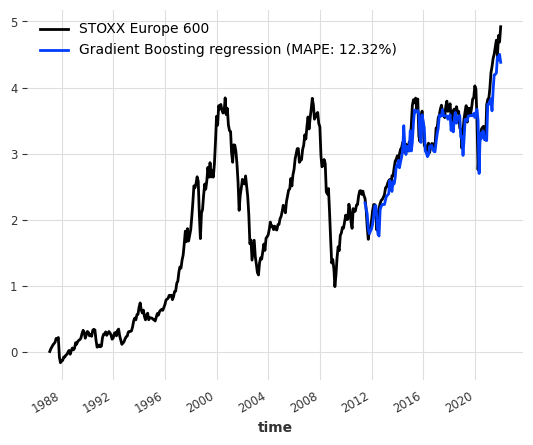

In [ ]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')

hf_gradient_boosting = gb_boosting.historical_forecasts(
    series= cum_returns,    # the target time series used to successively train and compute the historical forecasts.
    start= 0.7,             # first point in time at which a prediction is computed for a future time
    forecast_horizon= 1,    # the forecast horizon for the predictions
    verbose= True
)
# plot the historical forecasts and label it with MAPE
err = mape(hf_gradient_boosting, cum_returns)
hf_gradient_boosting['STOXX Europe 600'].plot(label= 'Gradient Boosting regression (MAPE: {:.2f}%)'.format(err))

# save this plot to wandb
wandb.log({'Historical Forecast Gradient Boosting': wandb.Image(plt)})

### Ada Boosting HF

  0%|          | 0/127 [00:00<?, ?it/s]

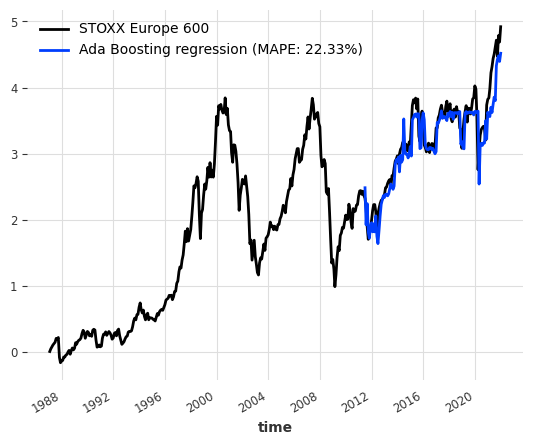

In [ ]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')

hf_ada_boosting = ada_boosting.historical_forecasts(
    series= cum_returns,    # the target time series used to successively train and compute the historical forecasts.
    start= 0.7,             # first point in time at which a prediction is computed for a future time
    forecast_horizon= 1,    # the forecast horizon for the predictions
    verbose= True
)
# plot the historical forecasts and label it with MAPE
err = mape(hf_ada_boosting, cum_returns)
hf_ada_boosting['STOXX Europe 600'].plot(label= 'Ada Boosting regression (MAPE: {:.2f}%)'.format(err))

# save this plot to wandb
wandb.log({'Historical Forecast Ada Boosting': wandb.Image(plt)})

### Extra Trees HF

  0%|          | 0/127 [00:00<?, ?it/s]

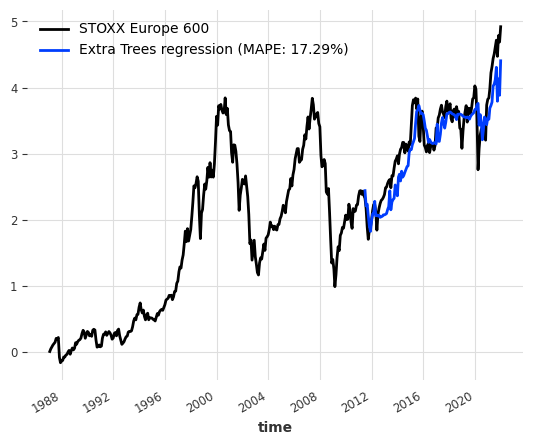

In [ ]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')

hf_extra_trees = extra_tree.historical_forecasts(
    series= cum_returns,    # the target time series used to successively train and compute the historical forecasts.
    start= 0.7,             # first point in time at which a prediction is computed for a future time
    forecast_horizon= 1,    # the forecast horizon for the predictions
    verbose= True
)
# plot the historical forecasts and label it with MAPE
err = mape(hf_extra_trees, cum_returns)
hf_extra_trees['STOXX Europe 600'].plot(label= 'Extra Trees regression (MAPE: {:.2f}%)'.format(err))

# save this plot to wandb
wandb.log({'Historical Forecast Extra Trees': wandb.Image(plt)})

### Support Vector HF

  0%|          | 0/127 [00:00<?, ?it/s]

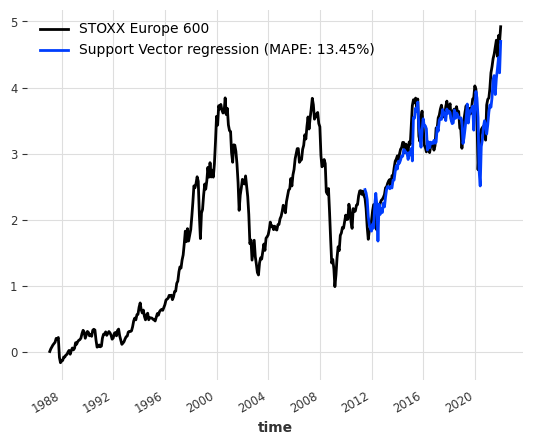

In [ ]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')

hf_support_vector = svr.historical_forecasts(
    series= cum_returns,    # the target time series used to successively train and compute the historical forecasts.
    start= 0.7,             # first point in time at which a prediction is computed for a future time
    forecast_horizon= 1,    # the forecast horizon for the predictions
    verbose= True
)
# plot the historical forecasts and label it with MAPE
err = mape(hf_support_vector, cum_returns)
hf_support_vector['STOXX Europe 600'].plot(label= 'Support Vector regression (MAPE: {:.2f}%)'.format(err))

# save this plot to wandb
wandb.log({'Historical Forecast Support Vector': wandb.Image(plt)})

# Questions & Next Steps

Gibt es weitere Hyperparameter die wir optimieren wollen?
- Kovariablen (vergangene und/oder zukünftige; bspw. benchmark)
- ist eine Ausweitung der bisher verwendeten Ranges Tuning notwendig oder kann dies so im Textfeld der Thesis erläutert werden.

Sind Ihnen bestimmte Fehler/Probleme im Code aufgefallen?


Meine nächsten Schritte:

- Berechnung von Forecasts und basierend darauf Erstellung erster Portfolien basierend auf Methoden aus der Portfolio Analysis.
- Berechnung klassischer Methoden wie Equal Weighting und Historical Avergage
- Vergleich dieser Methoden mittels relativer Werte in tabellarischer Form ähnlich zur Tabelle 2 aus "Does model complexity add value to asset allocation? Evidence from machine learning forecasting models"
